In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
import pickle
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import zero_one_loss
from sklearn.metrics import confusion_matrix

from keras import backend as K
import gc

In [ ]:
!git clone https://github.com/EdoardoGit/ML_Colab.git

Cloning into 'ML_Colab'...
remote: Enumerating objects: 24980, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 24980 (delta 0), reused 6 (delta 0), pack-reused 24974
Receiving objects: 100% (24980/24980), 895.68 MiB | 17.68 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (25003/25003), done.


In [ ]:
EARLY_STOP_PATIENCE=5
OUTPUT_LOSS_PATH="output_loss_fold"
OUTPUT_VAL_PATH="output_val_fold"
OUTPUT_CONF_PATH="output_conf_fold"
OUTPUT_MEAN_LOSS_PATH="output_mean_loss"
OUTPUT_MEAN_ACC_PATH="output_mean_acc"
OUTPUT_MEAN_CONF_PATH="output_mean_conf"

In [ ]:
pickle_path="/content/ML_Colab/Pickle_Files/"

pickle_in=open(pickle_path+"Gray_Shuffled_Data_p1.pickle","rb")
x_p1=pickle.load(pickle_in)

pickle_in=open(pickle_path+"Gray_Shuffled_Data_p2.pickle","rb")
x_p2=pickle.load(pickle_in)

pickle_in=open(pickle_path+"Gray_Shuffled_Labels.pickle","rb")
y=pickle.load(pickle_in)

In [ ]:
X = []
for data in x_p1:
  X.append(data)
for data in x_p2:
  X.append(data)
X=np.array(X)
X=X/255
y=np.array(y)

In [ ]:
print(len(X))
print(len(y))

24946
24946


In [ ]:
X.shape[1:]

(75, 75, 1)

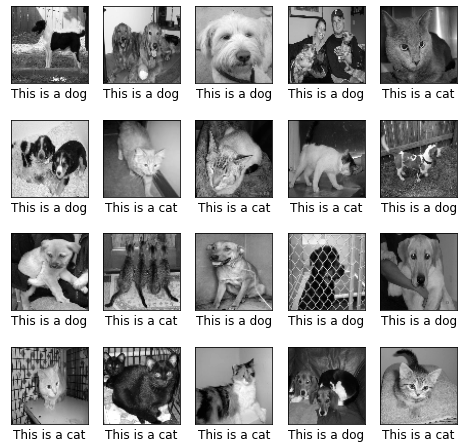

In [ ]:
#check dei primi 20 campioni
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'This is a {"dog" if y[i][0] == 1 else "cat"}', size=12)
plt.savefig('grid_example')
plt.show()


In [ ]:
#h->train history, path->dove salvare
def save_loss_plot(H,path):
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(H.history["loss"],label="train_loss")
  #plt.plot(H.history["val_loss"],label="val_loss")
  #plt.plot(H.history["categorical_accuracy"],label="train_acc")
  plt.plot(H.history["custom_zero_loss"],label="0-1_loss")
  #plt.plot(H.history["val_categorical_accuracy"],label="val_acc")
  plt.plot(H.history["val_custom_zero_loss"],label="val_0-1_loss")
  plt.title("Loss")
  plt.xlabel("Epoch #")
  plt.ylabel("Train Loss and 0-1 Loss")
  plt.legend()
  plt.savefig(path)

In [ ]:
#h->train history, path->dove salvare
def save_val_plot(H,path):
  plt.style.use("ggplot")
  plt.figure()
  #plt.plot(H.history["loss"],label="train_loss")
  #plt.plot(H.history["val_loss"],label="val_loss")
  plt.plot(H.history["categorical_accuracy"],label="train_acc")
  plt.plot(H.history["val_categorical_accuracy"],label="val_acc")
  #plt.plot(H.history["val_custom_zero_loss"],label="val_loss")
  plt.title("Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Train and Test Accuracy")
  plt.legend()
  plt.savefig(path)

In [ ]:
#h->data history, path->dove salvare
#definisco la funzione per visualizzare la confusion matrix delle fold
def save_conf_plot(y_true,y_pred,path):
  #converto gli array da (p,1-p) a (0/1)
  ypred_s=[]
  for data_pred in y_pred:
    if data_pred[0]>0.5:
      ypred_s.append(1)
    else:
      ypred_s.append(0)
  
  ytrue_s=[]
  for y_t in y_true:
    ytrue_s.append(int(y_t[0]))

  plt.figure()
  cfm = confusion_matrix(ytrue_s, ypred_s)
  print(cfm)
  ax= plt.subplot()
  sns.heatmap(cfm, annot=True, ax = ax, fmt='g');
  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels');
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(['cats', 'dogs'])
  ax.yaxis.set_ticklabels(['cats', 'dogs'])
  plt.savefig(path)

In [ ]:
#h->data history, path->dove salvare
#definisco la funzione per visualizzare la confusion matrix media
def save_mean_conf_plot(y_true,y_pred,path):
  #converto gli array da (p,1-p) a (0/1)
  ypred_s=[]
  for data_pred in y_pred:
    if data_pred[0]>0.5:
      ypred_s.append(1)
    else:
      ypred_s.append(0)
  
  ytrue_s=[]
  for y_t in y_true:
    ytrue_s.append(int(y_t[0]))

  plt.figure()
  cfm = confusion_matrix(ytrue_s, ypred_s)
  cfm=cfm/n_splits
  print(cfm)
  ax= plt.subplot()
  sns.heatmap(cfm, annot=True, ax = ax, fmt='g');
  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels');
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(['cats', 'dogs'])
  ax.yaxis.set_ticklabels(['cats', 'dogs'])
  plt.savefig(path)

In [ ]:
#h->data history, path->dove salvare
#definisco la funzione per visualizzare la loss media
def save_mean_loss_plot(mloss,mozloss,meanvalozloss,path):
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(mloss,label="train_loss")
  plt.plot(mozloss,label="train_0-1_loss")
  plt.plot(meanvalozloss,label="val_0-1_loss")
  plt.title("Loss")
  plt.xlabel("Epoch #")
  plt.ylabel("Train and Test Loss")
  plt.legend()
  plt.savefig(path)

In [ ]:
#h->data history, path->dove salvare
#definisco la funzione per visualizzare la accuracy media
def save_mean_acc_plot(macc,mvalacc,path):
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(macc,label="train_acc")
  plt.plot(mvalacc,label="val_acc")
  plt.title("Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Train and Test Accuracy")
  plt.legend()
  plt.savefig(path)

In [ ]:
m=tf.keras.metrics.CategoricalAccuracy()

In [ ]:
def custom_zero_loss(y_true, y_pred):
  m.reset_state()
  m.update_state(y_true,y_pred)
  return 1-m.result()

STANDARD 1 CONV LAYER

In [ ]:
#definisco l'architettura (STANDARD 1 CONV LAYER)
def model_builder():
  model = Sequential()
  
  #input layer & hidden layer
  model.add (Conv2D (64,(3,3),activation='relu',input_shape = X.shape[1:]))
  model.add (MaxPooling2D (pool_size=(2,2)))
  model.add (Flatten ())

  #output layer
  model.add(Dense(2, activation="softmax"))

  model.compile (
	loss = "categorical_crossentropy",
	optimizer = "adam",
	metrics = [tf.keras.metrics.CategoricalAccuracy(),custom_zero_loss]
  )

  return model

In [ ]:
#definisco training e crossvalidation
n_splits=5
n_epochs=10
n_batch=64

def train_and_crossvalidate(X_data,y_data,n_folds=n_splits,batch_size=n_batch):
  scores=[]
  check_pred=[]
  histories=[]
  y_mean_conf=[]

  #cross validation
  kf=KFold(n_folds)

  #splits
  FoldsSetN=0
  for train_index,test_index in kf.split(X_data):
    print('Fold Set #{0}'.format(FoldsSetN))
    X_train, y_train, X_test, y_test = X_data[train_index],y_data[train_index],X_data[test_index],y_data[test_index]

    #model
    model = model_builder()

    #fit
    history = model.fit(X_train,y_train,epochs=n_epochs,batch_size = n_batch,validation_data=(X_test,y_test))
    histories.append(history)
    save_loss_plot(history,OUTPUT_LOSS_PATH+'#{0}'.format(FoldsSetN))
    save_val_plot(history,OUTPUT_VAL_PATH+'#{0}'.format(FoldsSetN))
    y_conf=model.predict(X_test)
    y_mean_conf.append(y_conf)
    save_conf_plot(y_test,y_conf,OUTPUT_CONF_PATH+'#{0}'.format(FoldsSetN))
    fold_eval=model.evaluate(X_test,y_test)
    print(f'Model Evaluation for fold {FoldsSetN}: Loss {fold_eval[0]} ---- Acc {fold_eval[1]}')

    #zero-one loss
    ypred_test = model.predict (X_test)
    n_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=False)
    p_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=True)
    print(f'Zero-One Loss for fold {FoldsSetN}: {n_zol} n ---- {p_zol} %')

    scores.append({'val_loss':fold_eval[0], 
                   'val_acc':fold_eval[1],
                   'zero_one_n':n_zol,
                   'zero_one_p':p_zol})
    
    #memorizzo i primi 20
    y_check=model.predict (X_data[0:20])
    check_pred.append(y_check)

    #scores check
    #check=model.evaluate(X_test,y_test)
    #print(f'Score for fold {FoldsSetN}: {model.metrics_names[0]} of {check[0]}; {model.metrics_names[1]} of {check[1]*100}%')

    #clear model
    del model
    K.clear_session()
    gc.collect()

    FoldsSetN+=1
  return scores,check_pred,histories,y_mean_conf

Fold Set #0
Epoch 1/10
312/312 [==============================] - 89s 282ms/step - loss: 0.6487 - categorical_accuracy: 0.6563 - custom_zero_loss: 0.3436 - val_loss: 0.5585 - val_categorical_accuracy: 0.7218 - val_custom_zero_loss: 0.2782
Epoch 2/10
312/312 [==============================] - 88s 282ms/step - loss: 0.5228 - categorical_accuracy: 0.7471 - custom_zero_loss: 0.2529 - val_loss: 0.5547 - val_categorical_accuracy: 0.7158 - val_custom_zero_loss: 0.2842
Epoch 3/10
312/312 [==============================] - 87s 278ms/step - loss: 0.4804 - categorical_accuracy: 0.7732 - custom_zero_loss: 0.2268 - val_loss: 0.5279 - val_categorical_accuracy: 0.7409 - val_custom_zero_loss: 0.2591
Epoch 4/10
312/312 [==============================] - 87s 279ms/step - loss: 0.4533 - categorical_accuracy: 0.7878 - custom_zero_loss: 0.2122 - val_loss: 0.5192 - val_categorical_accuracy: 0.7491 - val_custom_zero_loss: 0.2509
Epoch 5/10
312/312 [==============================] - 87s 280ms/step - loss: 0.4

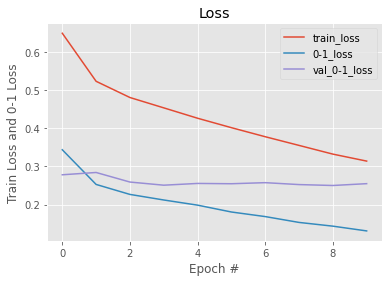

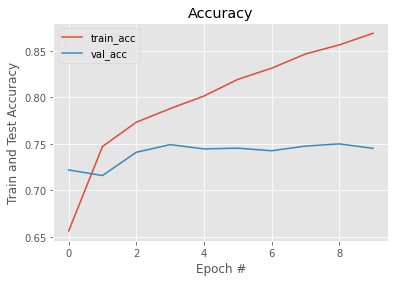

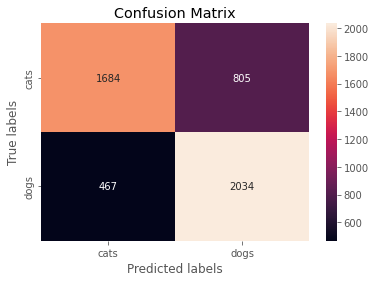

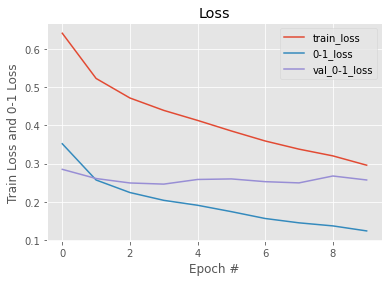

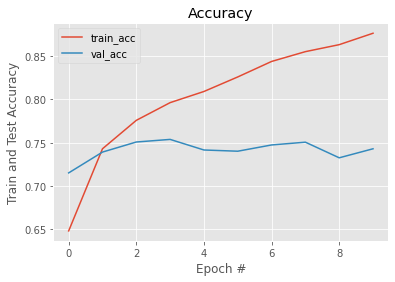

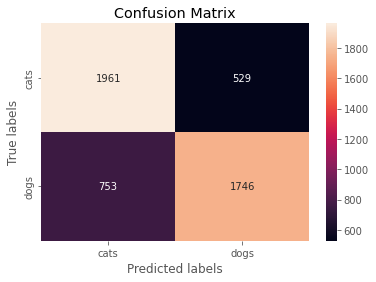

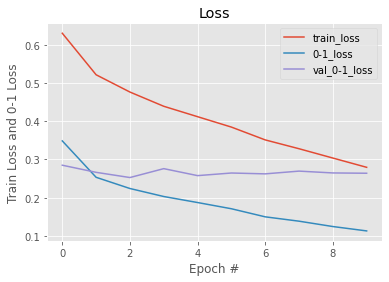

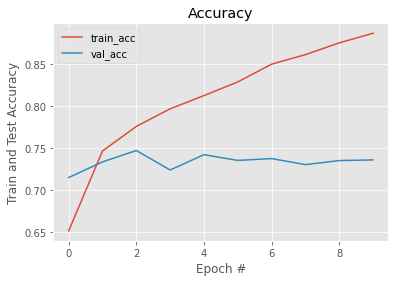

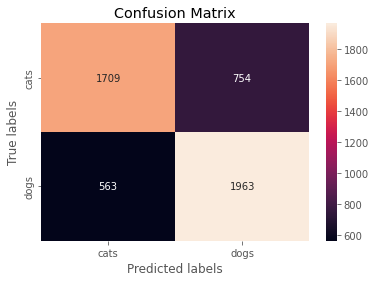

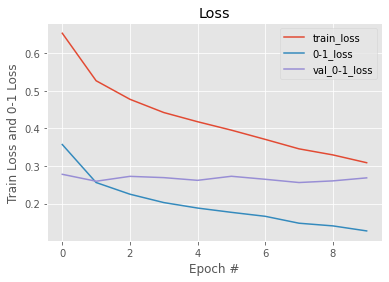

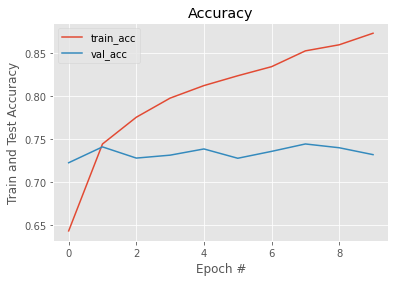

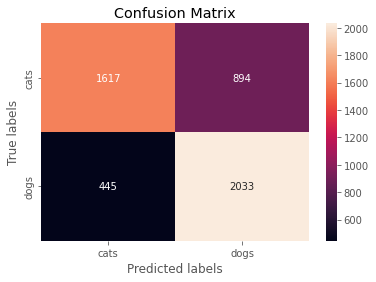

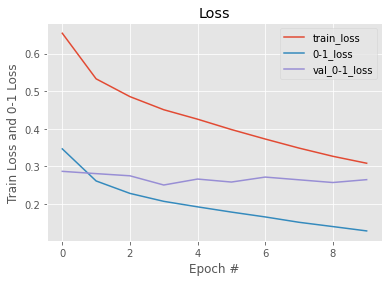

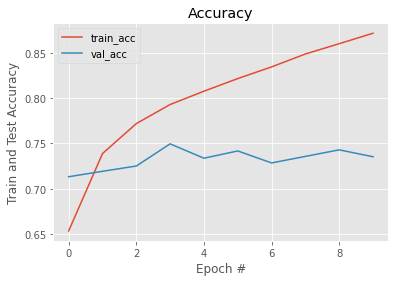

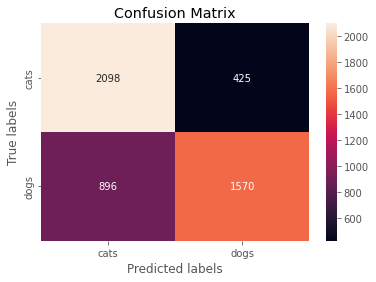

In [ ]:
scores,ypred,histories,y_mean_conf=train_and_crossvalidate(X,y)

In [ ]:
#Print degli scores
val_loss=[]
val_acc=[]
zero_one_N=[]
zero_one_P=[]
for s in scores:
  val_loss.append(s['val_loss'])
  val_acc.append(s['val_acc'])
  zero_one_N.append(s['zero_one_n'])
  zero_one_P.append(s['zero_one_p'])

print('Score per fold')
for i in range(n_splits):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {val_loss[i]} - Accuracy: {val_acc[i]}% - Zero-One N Loss: {zero_one_N[i]} - Zero-One Loss: {zero_one_P[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(val_loss)}')
print(f'> Accuracy: {np.mean(val_acc)}% (+- {np.std(val_acc)})')
print(f'> Zero-One N Loss: {np.mean(zero_one_N)} (+- {np.std(zero_one_N)})')
print(f'> Zero-One Loss: {np.mean(zero_one_P)}% (+- {np.std(zero_one_P)})')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.5837339758872986 - Accuracy: 0.7450901865959167% - Zero-One N Loss: 1272 - Zero-One Loss: 0.2549098196392786%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.5926339030265808 - Accuracy: 0.7430346608161926% - Zero-One N Loss: 1282 - Zero-One Loss: 0.25696532371216674%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.601264476776123 - Accuracy: 0.7360192537307739% - Zero-One N Loss: 1317 - Zero-One Loss: 0.2639807576668671%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.5916826128959656 - Accuracy: 0.7316095232963562% - Zero-One N Loss: 1339 - Zero-One Loss: 0.2683904590098216%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.5801448225975037 - Accuracy: 0.7352174520492554% - Zero-One N Loss: 1321 - Zero-One L

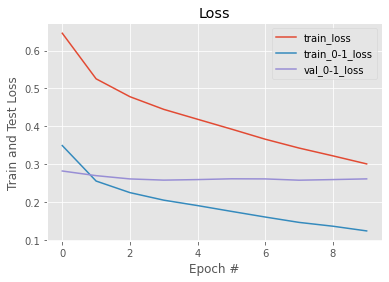

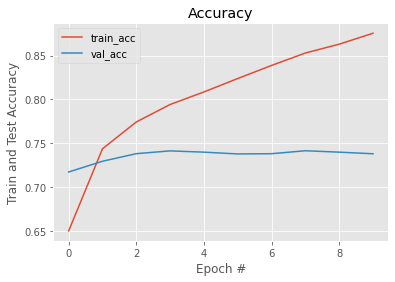

In [ ]:
#costruisco i grafici per la loss e l'accuracy media
mean_loss=np.zeros(n_epochs)
mean_oz_loss=np.zeros(n_epochs)
mean_val_oz_loss=np.zeros(n_epochs)
mean_acc=np.zeros(n_epochs)
mean_val_acc=np.zeros(n_epochs)
for h_loss in histories:
  mean_loss = np.add(mean_loss,h_loss.history["loss"])
  mean_oz_loss = np.add(mean_oz_loss,h_loss.history["custom_zero_loss"])
  mean_val_oz_loss = np.add(mean_val_oz_loss,h_loss.history["val_custom_zero_loss"])
  mean_acc= np.add(mean_acc,h_loss.history["categorical_accuracy"])
  mean_val_acc = np.add(mean_val_acc,h_loss.history["val_categorical_accuracy"])
mean_loss=mean_loss/n_splits
mean_oz_loss=mean_oz_loss/n_splits
mean_val_oz_loss=mean_val_oz_loss/n_splits
mean_acc=mean_acc/n_splits
mean_val_acc=mean_val_acc/n_splits

save_mean_loss_plot(mean_loss,mean_oz_loss,mean_val_oz_loss,OUTPUT_MEAN_LOSS_PATH)
save_mean_acc_plot(mean_acc,mean_val_acc,OUTPUT_MEAN_ACC_PATH)

[[1813.8  681.4]
 [ 624.8 1869.2]]


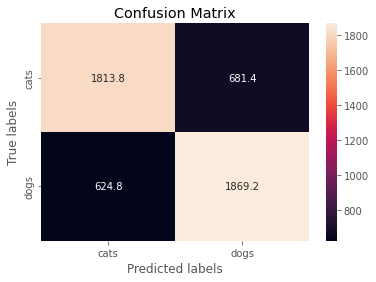

In [ ]:
#costruisco il grafico della matrice di confusione media
ypred_mean=[]
for y_fold in y_mean_conf:
  for y_label in y_fold:
    ypred_mean.append(y_label)
ypred_mean=np.array(ypred_mean)
save_mean_conf_plot(y,ypred_mean,OUTPUT_MEAN_CONF_PATH)

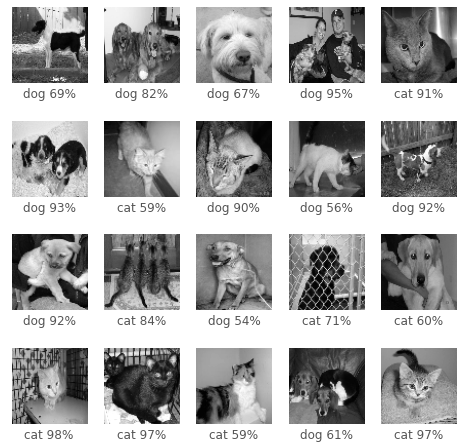

In [ ]:
#[0 1]-> cat,[1 0]->dog
data0=ypred[0]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data0[i][0]*100))+"%" if data0[i][0] > 0.5 else "cat "+str(int(data0[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold0')
plt.show()

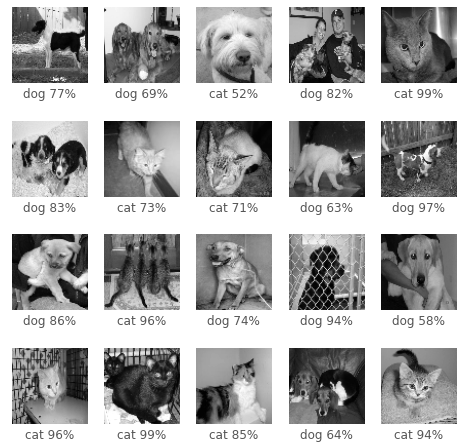

In [ ]:
data1=ypred[1]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data1[i][0]*100))+"%" if data1[i][0] > 0.5 else "cat "+str(int(data1[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold1')
plt.show()

STANDARD 1 CONV LAYER + 1 DENSE LAYER + EARLY STOPPING

In [ ]:
#definisco l'early stopping per il training
from tensorflow.keras.callbacks import EarlyStopping

stop_early=EarlyStopping(
    monitor="val_categorical_accuracy",
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True
)

In [ ]:
#definisco l'architettura (STANDARD 1 CONV LAYER)
def model_builder():
  model = Sequential()

  model.add (Conv2D (64,(3,3), activation='relu',input_shape = X.shape[1:]))
  model.add (MaxPooling2D (pool_size=(2,2)))
  model.add (Flatten ())
  model.add (Dense(64, activation='relu'))

  #output layer
  model.add(Dense(2, activation="softmax"))

  model.compile (
	loss = "categorical_crossentropy",
	optimizer = "adam",
	metrics = [tf.keras.metrics.CategoricalAccuracy(),custom_zero_loss]
  )

  return model

In [ ]:
#definisco training e crossvalidation
n_splits=5
n_epochs=20
n_batch=64

def train_and_crossvalidate(X_data,y_data,n_folds=n_splits,batch_size=n_batch):
  scores=[]
  check_pred=[]
  histories=[]
  y_mean_conf=[]

  #cross validation
  kf=KFold(n_folds)

  #splits
  FoldsSetN=0
  for train_index,test_index in kf.split(X_data):
    print('Fold Set #{0}'.format(FoldsSetN))
    X_train, y_train, X_test, y_test = X_data[train_index],y_data[train_index],X_data[test_index],y_data[test_index]

    #model
    model = model_builder()

    #fit del modello + grafici
    history = model.fit(X_train,y_train,epochs=n_epochs,batch_size = n_batch,callbacks=[stop_early],validation_data=(X_test,y_test))
    histories.append(history)
    save_loss_plot(history,OUTPUT_LOSS_PATH+'#{0}'.format(FoldsSetN))
    save_val_plot(history,OUTPUT_VAL_PATH+'#{0}'.format(FoldsSetN))
    y_conf=model.predict(X_test)
    y_mean_conf.append(y_conf)
    save_conf_plot(y_test,y_conf,OUTPUT_CONF_PATH+'#{0}'.format(FoldsSetN))
    fold_eval=model.evaluate(X_test,y_test)
    print(f'Model Evaluation for fold {FoldsSetN}: Loss {fold_eval[0]} ---- Acc {fold_eval[1]}')

    #zero-one loss
    ypred_test = model.predict (X_test)
    n_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=False)
    p_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=True)
    print(f'Zero-One Loss for fold {FoldsSetN}: {n_zol} n ---- {p_zol} %')

    scores.append({'val_loss':fold_eval[0], 
                   'val_acc':fold_eval[1],
                   'zero_one_n':n_zol,
                   'zero_one_p':p_zol})
    
    #memorizzo i primi 20
    y_check=model.predict (X_data[0:20])
    check_pred.append(y_check)

    #scores check
    #check=model.evaluate(X_test,y_test)
    #print(f'Score for fold {FoldsSetN}: {model.metrics_names[0]} of {check[0]}; {model.metrics_names[1]} of {check[1]*100}%')

    #clear model
    del model
    K.clear_session()
    gc.collect()

    FoldsSetN+=1
  return scores,check_pred,histories,y_mean_conf

Fold Set #0
Epoch 1/20
312/312 [==============================] - 112s 354ms/step - loss: 0.6492 - categorical_accuracy: 0.6381 - custom_zero_loss: 0.3618 - val_loss: 0.5832 - val_categorical_accuracy: 0.6968 - val_custom_zero_loss: 0.3032
Epoch 2/20
312/312 [==============================] - 111s 357ms/step - loss: 0.5440 - categorical_accuracy: 0.7257 - custom_zero_loss: 0.2743 - val_loss: 0.5449 - val_categorical_accuracy: 0.7251 - val_custom_zero_loss: 0.2750
Epoch 3/20
312/312 [==============================] - 108s 347ms/step - loss: 0.4932 - categorical_accuracy: 0.7623 - custom_zero_loss: 0.2377 - val_loss: 0.5380 - val_categorical_accuracy: 0.7305 - val_custom_zero_loss: 0.2696
Epoch 4/20
312/312 [==============================] - 108s 345ms/step - loss: 0.4599 - categorical_accuracy: 0.7847 - custom_zero_loss: 0.2153 - val_loss: 0.5311 - val_categorical_accuracy: 0.7439 - val_custom_zero_loss: 0.2561
Epoch 5/20
312/312 [==============================] - 109s 348ms/step - loss

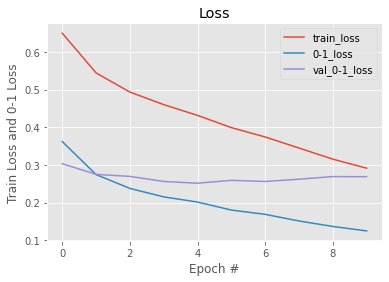

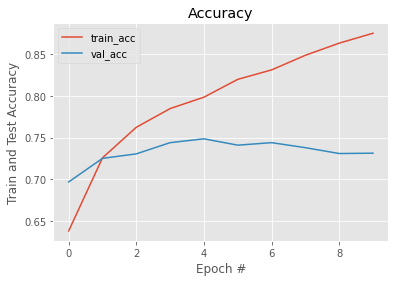

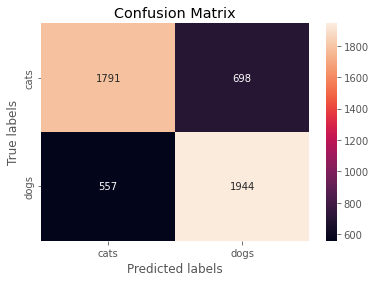

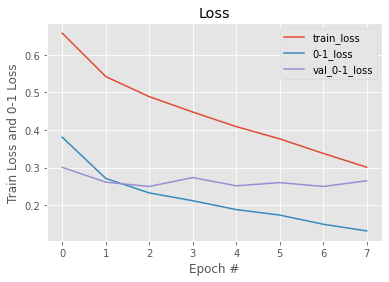

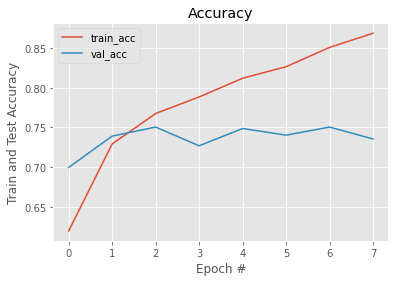

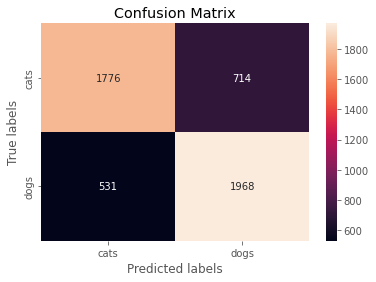

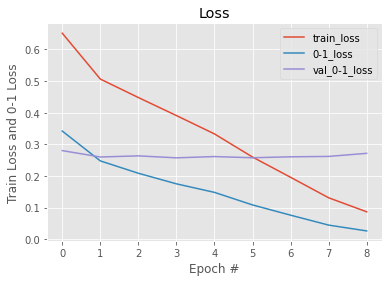

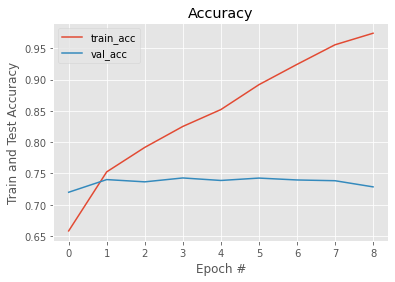

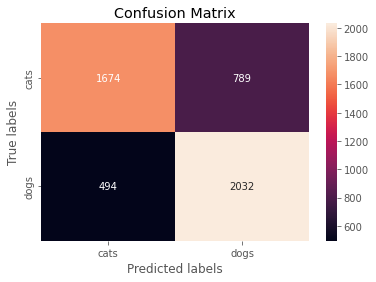

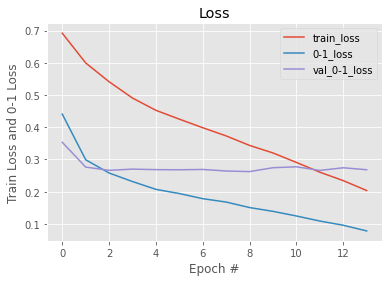

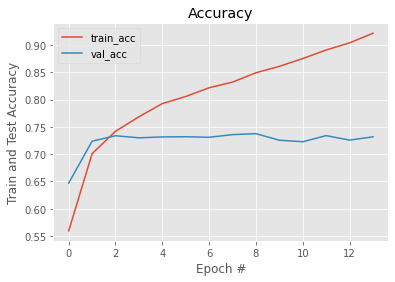

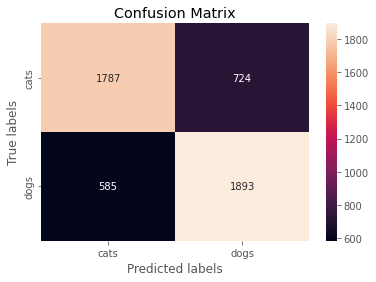

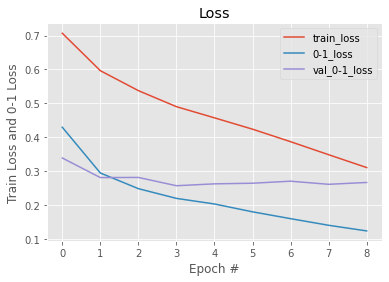

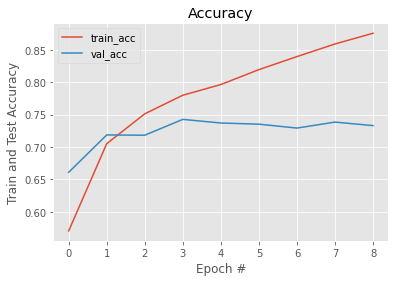

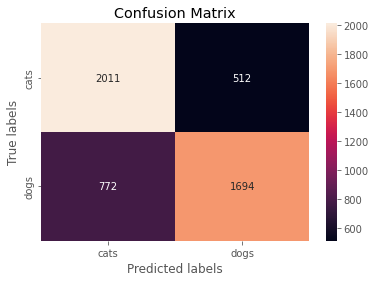

In [ ]:
scores,ypred,histories,y_mean_conf=train_and_crossvalidate(X,y)

In [ ]:
#Print degli scores
val_loss=[]
val_acc=[]
zero_one_N=[]
zero_one_P=[]
for s in scores:
  val_loss.append(s['val_loss'])
  val_acc.append(s['val_acc'])
  zero_one_N.append(s['zero_one_n'])
  zero_one_P.append(s['zero_one_p'])

print('Score per fold')
for i in range(n_splits):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {val_loss[i]} - Accuracy: {val_acc[i]}% - Zero-One N Loss: {zero_one_N[i]} - Zero-One Loss: {zero_one_P[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(val_loss)}')
print(f'> Accuracy: {np.mean(val_acc)}% (+- {np.std(val_acc)})')
print(f'> Zero-One N Loss: {np.mean(zero_one_N)} (+- {np.std(zero_one_N)})')
print(f'> Zero-One Loss: {np.mean(zero_one_P)}% (+- {np.std(zero_one_P)})')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.5304039120674133 - Accuracy: 0.7484970092773438% - Zero-One N Loss: 1255 - Zero-One Loss: 0.251503006012024%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.5252468585968018 - Accuracy: 0.7504509687423706% - Zero-One N Loss: 1245 - Zero-One Loss: 0.2495490078171978%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.5439708828926086 - Accuracy: 0.742834210395813% - Zero-One N Loss: 1283 - Zero-One Loss: 0.257165764682301%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.5821496844291687 - Accuracy: 0.7376227974891663% - Zero-One N Loss: 1309 - Zero-One Loss: 0.2623772299057927%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.5311365127563477 - Accuracy: 0.7426338195800781% - Zero-One N Loss: 1284 - Zero-One Loss

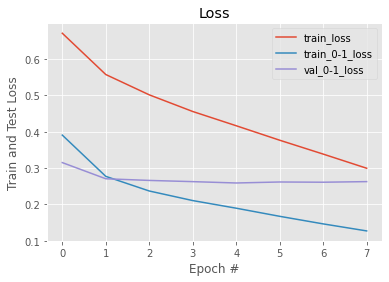

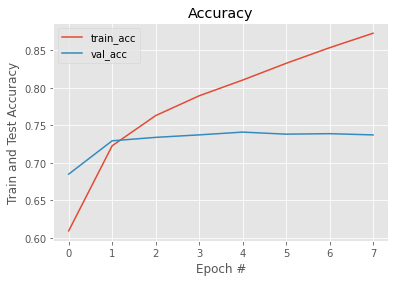

In [ ]:
#costruisco i grafici per la loss e l'accuracy media
mean_loss=np.zeros(n_epochs)
mean_oz_loss=np.zeros(n_epochs)
mean_val_oz_loss=np.zeros(n_epochs)
mean_acc=np.zeros(n_epochs)
mean_val_acc=np.zeros(n_epochs)
min=n_epochs
for h_loss in histories:
  mean_loss = np.add(mean_loss,np.resize(h_loss.history["loss"],(20,)))
  mean_oz_loss = np.add(mean_oz_loss,np.resize(h_loss.history["custom_zero_loss"],(20,)))
  mean_val_oz_loss = np.add(mean_val_oz_loss,np.resize(h_loss.history["val_custom_zero_loss"],(20,)))
  mean_acc= np.add(mean_acc,np.resize(h_loss.history["categorical_accuracy"],(20,)))
  mean_val_acc = np.add(mean_val_acc,np.resize(h_loss.history["val_categorical_accuracy"],(20,)))
  if(len(h_loss.history["loss"])<min):
    min=len(h_loss.history["loss"])
mean_loss=np.resize(mean_loss/n_splits,(min,))
mean_oz_loss=np.resize(mean_oz_loss/n_splits,(min,))
mean_val_oz_loss=np.resize(mean_val_oz_loss/n_splits,(min,))
mean_acc=np.resize(mean_acc/n_splits,(min,))
mean_val_acc=np.resize(mean_val_acc/n_splits,(min,))

save_mean_loss_plot(mean_loss,mean_oz_loss,mean_val_oz_loss,OUTPUT_MEAN_LOSS_PATH)
save_mean_acc_plot(mean_acc,mean_val_acc,OUTPUT_MEAN_ACC_PATH)

[[1807.8  687.4]
 [ 587.8 1906.2]]


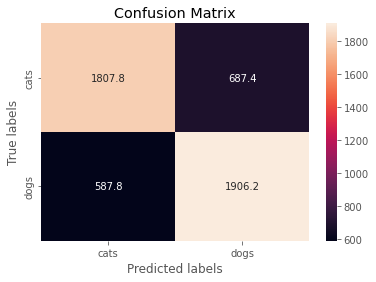

In [ ]:
#costruisco il grafico della matrice di confusione media
ypred_mean=[]
for y_fold in y_mean_conf:
  for y_label in y_fold:
    ypred_mean.append(y_label)
ypred_mean=np.array(ypred_mean)
save_mean_conf_plot(y,ypred_mean,OUTPUT_MEAN_CONF_PATH)

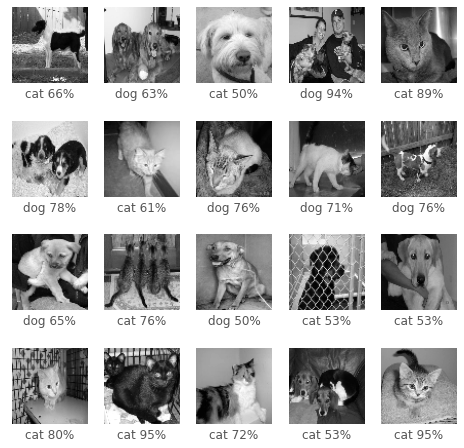

In [ ]:
#[0 1]-> cat,[1 0]->dog
data0=ypred[0]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data0[i][0]*100))+"%" if data0[i][0] > 0.5 else "cat "+str(int(data0[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold0')
plt.show()

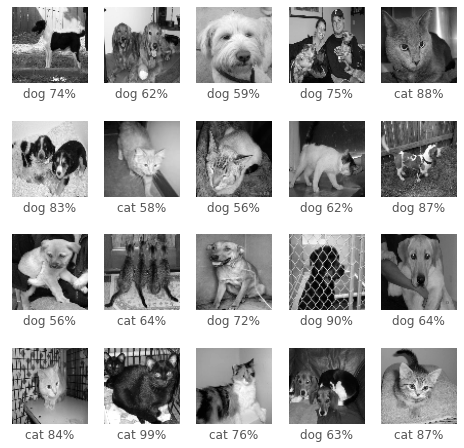

In [ ]:
data1=ypred[1]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data1[i][0]*100))+"%" if data1[i][0] > 0.5 else "cat "+str(int(data1[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold1')
plt.show()

STANDARD 2 CONV + 1 DENSE + DROPOUT + EARLYSTOP

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

stop_early=EarlyStopping(
    monitor="val_categorical_accuracy",
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True
)

In [ ]:
#definisco l'architettura (STANDARD 2 CONV LAYERS)
def model_builder():
  model = Sequential()

  model.add (Conv2D (32,(3,3), activation='relu',input_shape = X.shape[1:]))
  model.add (MaxPooling2D (pool_size=(2,2)))
  model.add (Conv2D (64,(3,3), activation='relu'))
  model.add (MaxPooling2D (pool_size=(2,2)))
  model.add (Flatten ())
  model.add (Dropout (0.5))
  model.add (Dense(64, activation='relu'))
  model.add (Dropout (0.5))

  #output layer
  model.add(Dense(2, activation="softmax"))

  model.compile (
	loss = "categorical_crossentropy",
	optimizer = "adam",
	metrics = [tf.keras.metrics.CategoricalAccuracy(),custom_zero_loss]
  )

  return model

In [ ]:
n_splits=5
n_epochs=20
n_batch=64

def train_and_crossvalidate(X_data,y_data,n_folds=n_splits,batch_size=n_batch):
  scores=[]
  check_pred=[]
  histories=[]
  y_mean_conf=[]

  #cross validation
  kf=KFold(n_folds)

  #splits
  FoldsSetN=0
  for train_index,test_index in kf.split(X_data):
    print('Fold Set #{0}'.format(FoldsSetN))
    X_train, y_train, X_test, y_test = X_data[train_index],y_data[train_index],X_data[test_index],y_data[test_index]

    #model
    model = model_builder()

    #fit
    history = model.fit(X_train,y_train,epochs=n_epochs,batch_size = n_batch,callbacks=[stop_early],validation_data=(X_test,y_test))
    histories.append(history)
    save_loss_plot(history,OUTPUT_LOSS_PATH+'#{0}'.format(FoldsSetN))
    save_val_plot(history,OUTPUT_VAL_PATH+'#{0}'.format(FoldsSetN))
    y_conf=model.predict(X_test)
    y_mean_conf.append(y_conf)
    save_conf_plot(y_test,y_conf,OUTPUT_CONF_PATH+'#{0}'.format(FoldsSetN))
    fold_eval=model.evaluate(X_test,y_test)
    print(f'Model Evaluation for fold {FoldsSetN}: Loss {fold_eval[0]} ---- Acc {fold_eval[1]}')

    #zero-one loss
    ypred_test = model.predict (X_test)
    n_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=False)
    p_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=True)
    print(f'Zero-One Loss for fold {FoldsSetN}: {n_zol} n ---- {p_zol} %')

    scores.append({'val_loss':fold_eval[0], 
                   'val_acc':fold_eval[1],
                   'zero_one_n':n_zol,
                   'zero_one_p':p_zol})
    
    #memorizzo i primi 20
    y_check=model.predict (X_data[0:20])
    check_pred.append(y_check)

    #scores check
    #check=model.evaluate(X_test,y_test)
    #print(f'Score for fold {FoldsSetN}: {model.metrics_names[0]} of {check[0]}; {model.metrics_names[1]} of {check[1]*100}%')

    #clear model
    del model
    K.clear_session()
    gc.collect()

    FoldsSetN+=1
  return scores,check_pred,histories,y_mean_conf

Fold Set #0
Epoch 1/20
312/312 [==============================] - 14s 16ms/step - loss: 0.6417 - categorical_accuracy: 0.6257 - custom_zero_loss: 0.3742 - val_loss: 0.5795 - val_categorical_accuracy: 0.6904 - val_custom_zero_loss: 0.3096
Epoch 2/20
312/312 [==============================] - 5s 14ms/step - loss: 0.5416 - categorical_accuracy: 0.7293 - custom_zero_loss: 0.2707 - val_loss: 0.4934 - val_categorical_accuracy: 0.7617 - val_custom_zero_loss: 0.2383
Epoch 3/20
312/312 [==============================] - 4s 14ms/step - loss: 0.4941 - categorical_accuracy: 0.7657 - custom_zero_loss: 0.2343 - val_loss: 0.4723 - val_categorical_accuracy: 0.7745 - val_custom_zero_loss: 0.2255
Epoch 4/20
312/312 [==============================] - 4s 14ms/step - loss: 0.4585 - categorical_accuracy: 0.7868 - custom_zero_loss: 0.2131 - val_loss: 0.4558 - val_categorical_accuracy: 0.7868 - val_custom_zero_loss: 0.2132
Epoch 5/20
312/312 [==============================] - 5s 15ms/step - loss: 0.4341 - cat

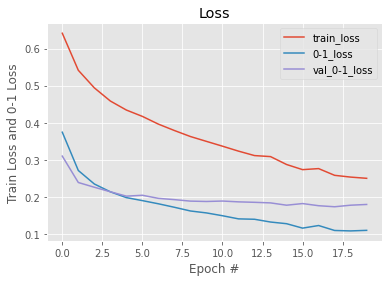

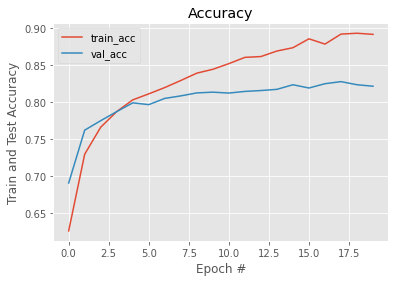

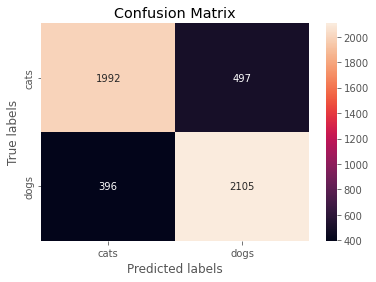

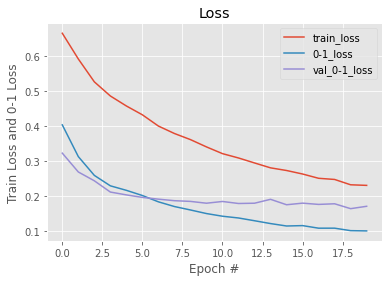

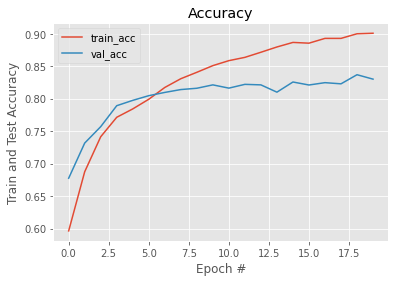

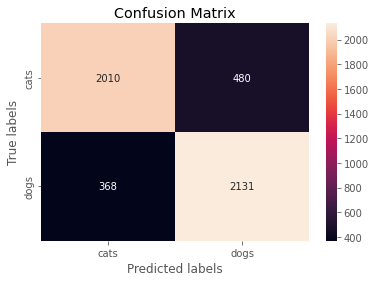

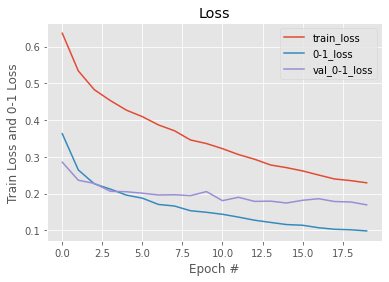

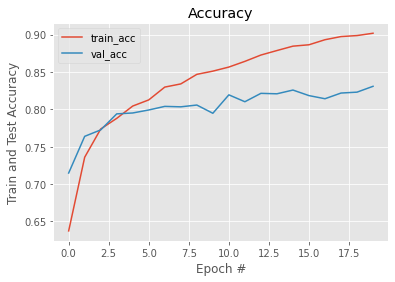

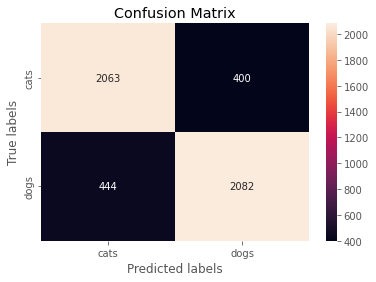

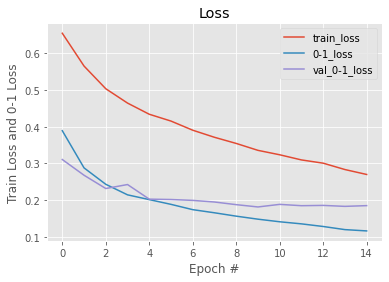

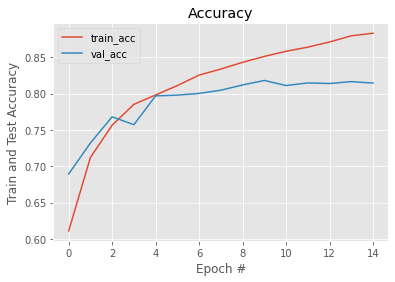

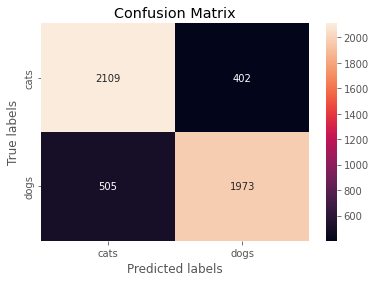

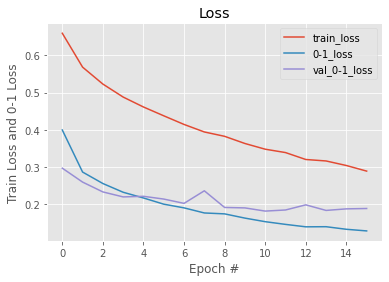

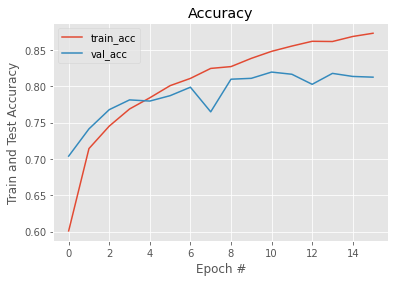

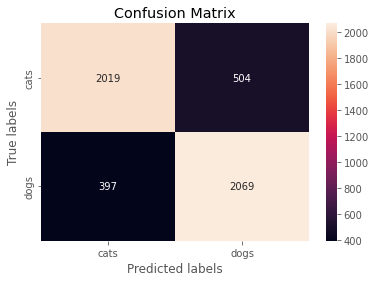

In [ ]:
scores,ypred,histories,y_mean_conf=train_and_crossvalidate(X,y)

In [ ]:
#Print degli scores
val_loss=[]
val_acc=[]
zero_one_N=[]
zero_one_P=[]
for s in scores:
  val_loss.append(s['val_loss'])
  val_acc.append(s['val_acc'])
  zero_one_N.append(s['zero_one_n'])
  zero_one_P.append(s['zero_one_p'])

print('Score per fold')
for i in range(n_splits):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {val_loss[i]} - Accuracy: {val_acc[i]}% - Zero-One N Loss: {zero_one_N[i]} - Zero-One Loss: {zero_one_P[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(val_loss)}')
print(f'> Accuracy: {np.mean(val_acc)}% (+- {np.std(val_acc)})')
print(f'> Zero-One N Loss: {np.mean(zero_one_N)} (+- {np.std(zero_one_N)})')
print(f'> Zero-One Loss: {np.mean(zero_one_P)}% (+- {np.std(zero_one_P)})')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.4290526807308197 - Accuracy: 0.8210420608520508% - Zero-One N Loss: 893 - Zero-One Loss: 0.17895791583166332%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.4015843868255615 - Accuracy: 0.8300260305404663% - Zero-One N Loss: 848 - Zero-One Loss: 0.16997394267388255%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.43444523215293884 - Accuracy: 0.8308278322219849% - Zero-One N Loss: 844 - Zero-One Loss: 0.16917217879334534%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.4088529050350189 - Accuracy: 0.8182000517845154% - Zero-One N Loss: 907 - Zero-One Loss: 0.18179995991180598%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.4153629243373871 - Accuracy: 0.8194026947021484% - Zero-One N Loss: 901 - Zero-One L

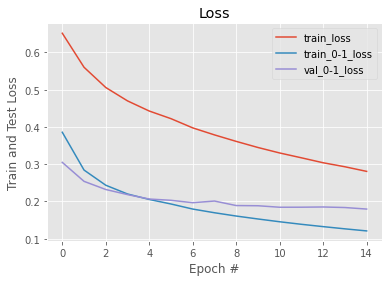

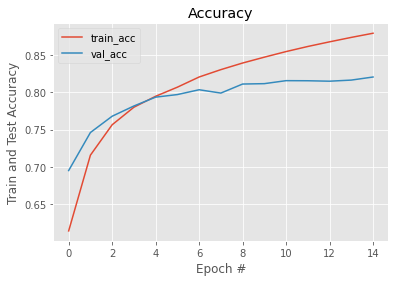

In [ ]:
#costruisco i grafici per la loss e l'accuracy media
mean_loss=np.zeros(n_epochs)
mean_oz_loss=np.zeros(n_epochs)
mean_val_oz_loss=np.zeros(n_epochs)
mean_acc=np.zeros(n_epochs)
mean_val_acc=np.zeros(n_epochs)
min=n_epochs
for h_loss in histories:
  mean_loss = np.add(mean_loss,np.resize(h_loss.history["loss"],(n_epochs,)))
  mean_oz_loss = np.add(mean_oz_loss,np.resize(h_loss.history["custom_zero_loss"],(n_epochs,)))
  mean_val_oz_loss = np.add(mean_val_oz_loss,np.resize(h_loss.history["val_custom_zero_loss"],(n_epochs,)))
  mean_acc= np.add(mean_acc,np.resize(h_loss.history["categorical_accuracy"],(n_epochs,)))
  mean_val_acc = np.add(mean_val_acc,np.resize(h_loss.history["val_categorical_accuracy"],(n_epochs,)))
  if(len(h_loss.history["loss"])<min):
    min=len(h_loss.history["loss"])
mean_loss=np.resize(mean_loss/n_splits,(min,))
mean_oz_loss=np.resize(mean_oz_loss/n_splits,(min,))
mean_val_oz_loss=np.resize(mean_val_oz_loss/n_splits,(min,))
mean_acc=np.resize(mean_acc/n_splits,(min,))
mean_val_acc=np.resize(mean_val_acc/n_splits,(min,))

save_mean_loss_plot(mean_loss,mean_oz_loss,mean_val_oz_loss,OUTPUT_MEAN_LOSS_PATH)
save_mean_acc_plot(mean_acc,mean_val_acc,OUTPUT_MEAN_ACC_PATH)

[[2038.6  456.6]
 [ 422.  2072. ]]


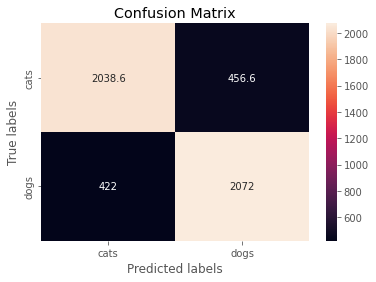

In [ ]:
#costruisco il grafico della matrice di confusione media
ypred_mean=[]
for y_fold in y_mean_conf:
  for y_label in y_fold:
    ypred_mean.append(y_label)
ypred_mean=np.array(ypred_mean)
save_mean_conf_plot(y,ypred_mean,OUTPUT_MEAN_CONF_PATH)

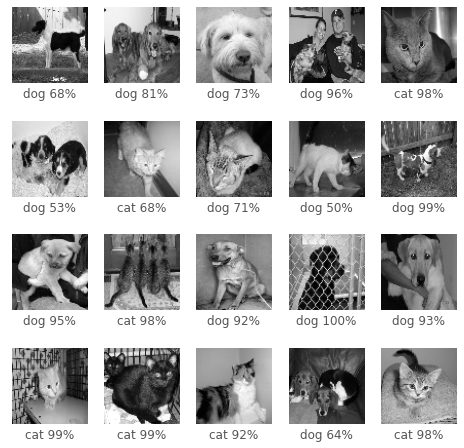

In [ ]:
#[0 1]-> cat,[1 0]->dog
data0=ypred[0]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data0[i][0]*100))+"%" if data0[i][0] > 0.5 else "cat "+str(int(data0[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold0')
plt.show()

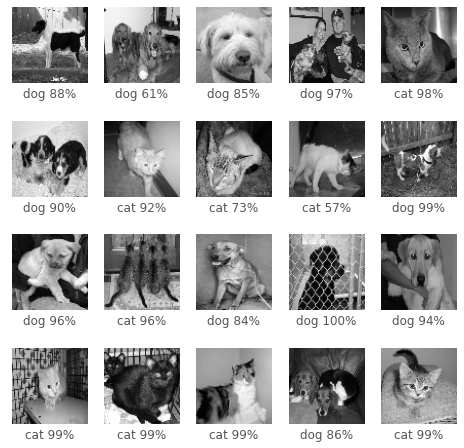

In [ ]:
data1=ypred[1]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data1[i][0]*100))+"%" if data1[i][0] > 0.5 else "cat "+str(int(data1[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold1')
plt.show()

STANDARD ESEMPIO TUTORIAL + EARLYSTOP

In [ ]:
#definisco l'early stopping per il training
from tensorflow.keras.callbacks import EarlyStopping

stop_early=EarlyStopping(
    monitor="val_categorical_accuracy",
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True
)

In [ ]:
#definisco l'architettura (STANDARD 3 CONV LAYERS)
def model_builder():
  model = Sequential()
  
  #input layer
  model.add (Conv2D (32,(3,3), activation='relu',input_shape = X.shape[1:]))

  #hidden layer
  model.add (MaxPooling2D (pool_size=(2,2)))
  model.add (Conv2D (64,(3,3), activation='relu'))
  model.add (MaxPooling2D (pool_size=(2,2)))
  model.add (Conv2D (64,(3,3), activation='relu'))
  model.add (Flatten ())
  model.add (Dropout (0.5))
  model.add (Dense(64, activation='relu'))
  model.add (Dropout (0.5))

  #output layer
  model.add(Dense(2, activation="softmax"))

  model.compile (
	loss = "categorical_crossentropy",
	optimizer = keras.optimizers.Adam(learning_rate=0.001),
	metrics = [tf.keras.metrics.CategoricalAccuracy(),custom_zero_loss]
  )

  return model

In [ ]:
#definisco training e crossvalidation
n_splits=5
n_epochs=20
n_batch=64

def train_and_crossvalidate(X_data,y_data,n_folds=n_splits,batch_size=n_batch):
  scores=[]
  check_pred=[]
  histories=[]
  y_mean_conf=[]

  #cross validation
  kf=KFold(n_folds)

  #splits
  FoldsSetN=0
  for train_index,test_index in kf.split(X_data):
    print('Fold Set #{0}'.format(FoldsSetN))
    X_train, y_train, X_test, y_test = X_data[train_index],y_data[train_index],X_data[test_index],y_data[test_index]

    #model
    model = model_builder()

    #fit
    history = model.fit(X_train,y_train,epochs=n_epochs,batch_size = n_batch,callbacks=[stop_early],validation_data=(X_test,y_test))
    histories.append(history)
    save_loss_plot(history,OUTPUT_LOSS_PATH+'#{0}'.format(FoldsSetN))
    save_val_plot(history,OUTPUT_VAL_PATH+'#{0}'.format(FoldsSetN))
    y_conf=model.predict(X_test)
    y_mean_conf.append(y_conf)
    save_conf_plot(y_test,y_conf,OUTPUT_CONF_PATH+'#{0}'.format(FoldsSetN))
    fold_eval=model.evaluate(X_test,y_test)
    print(f'Model Evaluation for fold {FoldsSetN}: Loss {fold_eval[0]} ---- Acc {fold_eval[1]}')

    #zero-one loss
    ypred_test = model.predict (X_test)
    n_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=False)
    p_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=True)
    print(f'Zero-One Loss for fold {FoldsSetN}: {n_zol} n ---- {p_zol} ')

    scores.append({'val_loss':fold_eval[0], 
                   'val_acc':fold_eval[1],
                   'zero_one_n':n_zol,
                   'zero_one_p':p_zol})
    
    #memorizzo i primi 20
    y_check=model.predict (X_data[0:20])
    check_pred.append(y_check)

    #scores check
    #check=model.evaluate(X_test,y_test)
    #print(f'Score for fold {FoldsSetN}: {model.metrics_names[0]} of {check[0]}; {model.metrics_names[1]} of {check[1]*100}%')

    #clear model
    del model
    K.clear_session()
    gc.collect()

    FoldsSetN+=1
  return scores,check_pred,histories,y_mean_conf

Fold Set #0
Epoch 1/20
312/312 [==============================] - 16s 16ms/step - loss: 0.6757 - categorical_accuracy: 0.5654 - custom_zero_loss: 0.4346 - val_loss: 0.6466 - val_categorical_accuracy: 0.6198 - val_custom_zero_loss: 0.3802
Epoch 2/20
312/312 [==============================] - 4s 14ms/step - loss: 0.5953 - categorical_accuracy: 0.6876 - custom_zero_loss: 0.3125 - val_loss: 0.5489 - val_categorical_accuracy: 0.7208 - val_custom_zero_loss: 0.2792
Epoch 3/20
312/312 [==============================] - 4s 14ms/step - loss: 0.5173 - categorical_accuracy: 0.7463 - custom_zero_loss: 0.2537 - val_loss: 0.4993 - val_categorical_accuracy: 0.7603 - val_custom_zero_loss: 0.2397
Epoch 4/20
312/312 [==============================] - 4s 14ms/step - loss: 0.4700 - categorical_accuracy: 0.7796 - custom_zero_loss: 0.2205 - val_loss: 0.4409 - val_categorical_accuracy: 0.7960 - val_custom_zero_loss: 0.2040
Epoch 5/20
312/312 [==============================] - 4s 14ms/step - loss: 0.4344 - cat

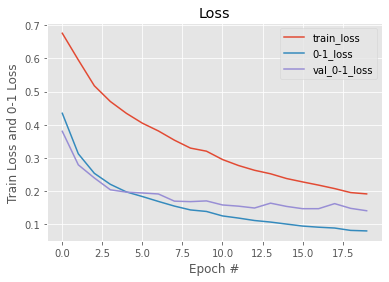

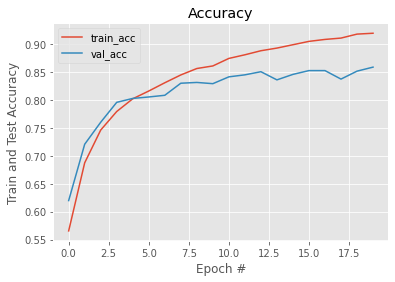

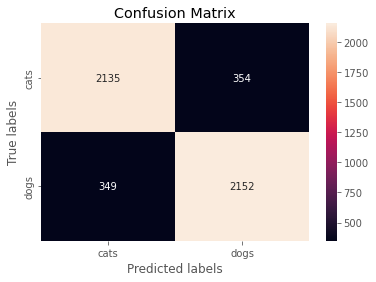

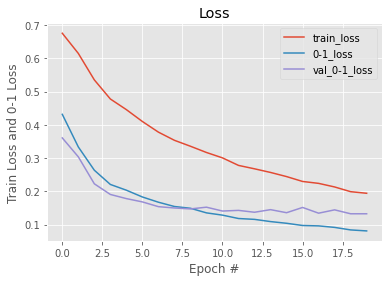

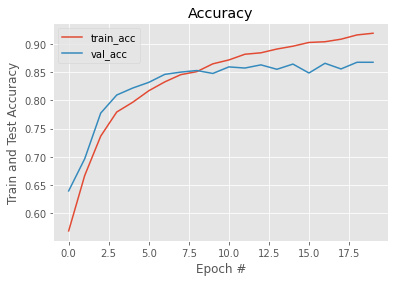

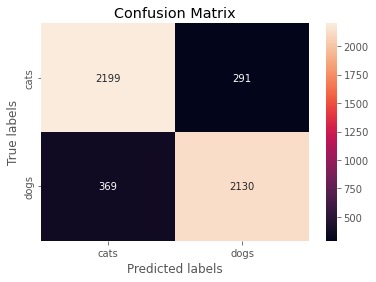

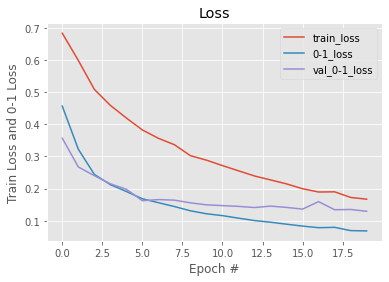

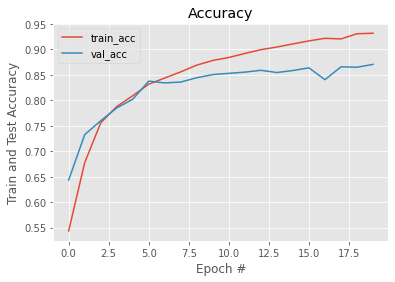

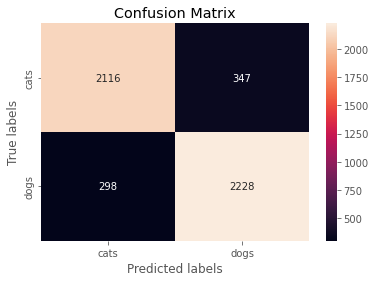

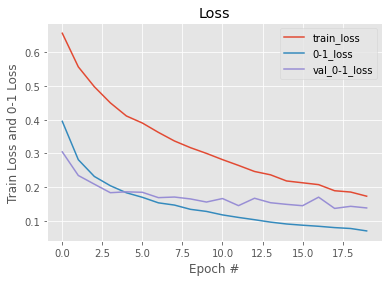

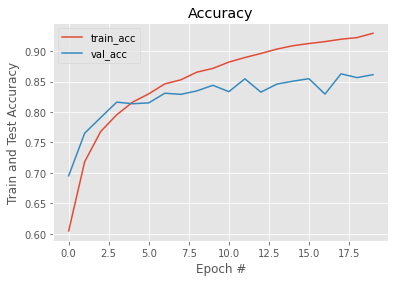

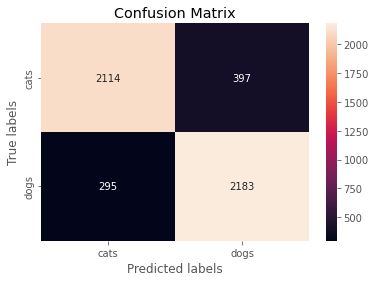

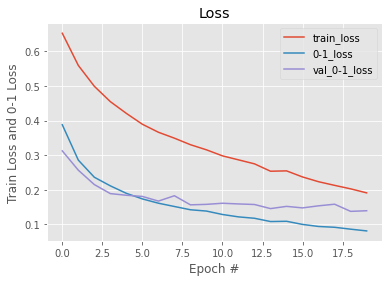

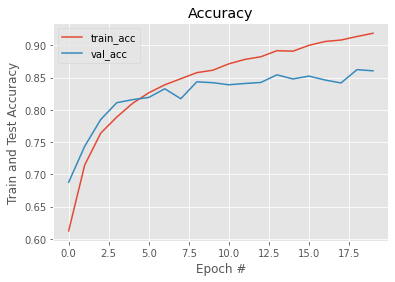

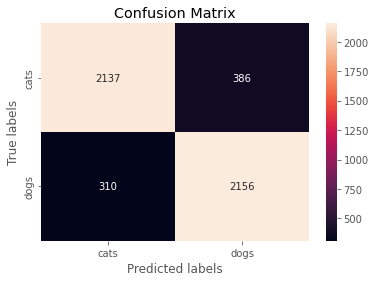

In [ ]:
scores,ypred,histories,y_mean_conf=train_and_crossvalidate(X,y)

In [ ]:
#Print degli scores
val_loss=[]
val_acc=[]
zero_one_N=[]
zero_one_P=[]
for s in scores:
  val_loss.append(s['val_loss'])
  val_acc.append(s['val_acc'])
  zero_one_N.append(s['zero_one_n'])
  zero_one_P.append(s['zero_one_p'])

print('Score per fold')
for i in range(n_splits):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {val_loss[i]} - Accuracy: {val_acc[i]} - Zero-One N Loss: {zero_one_N[i]} - Zero-One Loss: {zero_one_P[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(val_loss)}')
print(f'> Accuracy: {np.mean(val_acc)} (+- {np.std(val_acc)})')
print(f'> Zero-One N Loss: {np.mean(zero_one_N)} (+- {np.std(zero_one_N)})')
print(f'> Zero-One Loss: {np.mean(zero_one_P)} (+- {np.std(zero_one_P)})')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.3791038990020752 - Accuracy: 0.8591182231903076 - Zero-One N Loss: 703 - Zero-One Loss: 0.14088176352705406
------------------------------------------------------------------------
> Fold 2 - Loss: 0.33730819821357727 - Accuracy: 0.8677089810371399 - Zero-One N Loss: 660 - Zero-One Loss: 0.13229104028863503
------------------------------------------------------------------------
> Fold 3 - Loss: 0.370612233877182 - Accuracy: 0.8707155585289001 - Zero-One N Loss: 645 - Zero-One Loss: 0.12928442573662058
------------------------------------------------------------------------
> Fold 4 - Loss: 0.3935149908065796 - Accuracy: 0.8612948656082153 - Zero-One N Loss: 692 - Zero-One Loss: 0.13870515133293249
------------------------------------------------------------------------
> Fold 5 - Loss: 0.3817075490951538 - Accuracy: 0.8604930639266968 - Zero-One N Loss: 696 - Zero-One Loss: 0.139

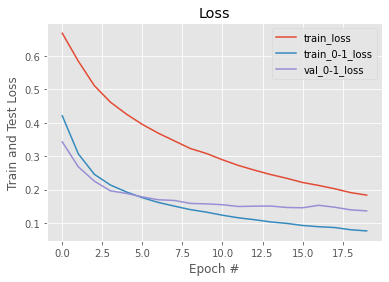

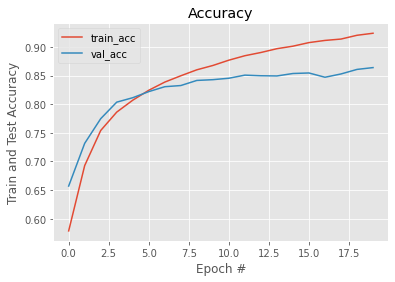

In [ ]:
#costruisco i grafici per la loss e l'accuracy media
mean_loss=np.zeros(n_epochs)
mean_oz_loss=np.zeros(n_epochs)
mean_val_oz_loss=np.zeros(n_epochs)
mean_acc=np.zeros(n_epochs)
mean_val_acc=np.zeros(n_epochs)
min=n_epochs
for h_loss in histories:
  mean_loss = np.add(mean_loss,np.resize(h_loss.history["loss"],(n_epochs,)))
  mean_oz_loss = np.add(mean_oz_loss,np.resize(h_loss.history["custom_zero_loss"],(n_epochs,)))
  mean_val_oz_loss = np.add(mean_val_oz_loss,np.resize(h_loss.history["val_custom_zero_loss"],(n_epochs,)))
  mean_acc= np.add(mean_acc,np.resize(h_loss.history["categorical_accuracy"],(n_epochs,)))
  mean_val_acc = np.add(mean_val_acc,np.resize(h_loss.history["val_categorical_accuracy"],(n_epochs,)))
  if(len(h_loss.history["loss"])<min):
    min=len(h_loss.history["loss"])
mean_loss=np.resize(mean_loss/n_splits,(min,))
mean_oz_loss=np.resize(mean_oz_loss/n_splits,(min,))
mean_val_oz_loss=np.resize(mean_val_oz_loss/n_splits,(min,))
mean_acc=np.resize(mean_acc/n_splits,(min,))
mean_val_acc=np.resize(mean_val_acc/n_splits,(min,))

save_mean_loss_plot(mean_loss,mean_oz_loss,mean_val_oz_loss,OUTPUT_MEAN_LOSS_PATH)
save_mean_acc_plot(mean_acc,mean_val_acc,OUTPUT_MEAN_ACC_PATH)

[[2140.2  355. ]
 [ 324.2 2169.8]]


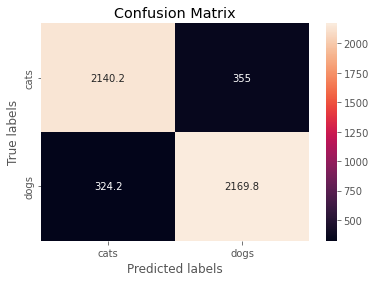

In [ ]:
#costruisco il grafico della matrice di confusione media
ypred_mean=[]
for y_fold in y_mean_conf:
  for y_label in y_fold:
    ypred_mean.append(y_label)
ypred_mean=np.array(ypred_mean)
save_mean_conf_plot(y,ypred_mean,OUTPUT_MEAN_CONF_PATH)

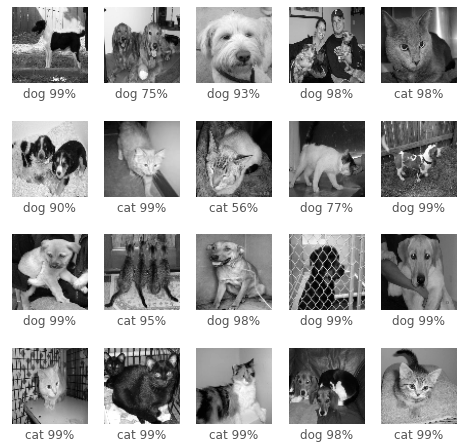

In [ ]:
#[0 1]-> cat,[1 0]->dog
data0=ypred[0]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data0[i][0]*100))+"%" if data0[i][0] > 0.5 else "cat "+str(int(data0[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold0')
plt.show()

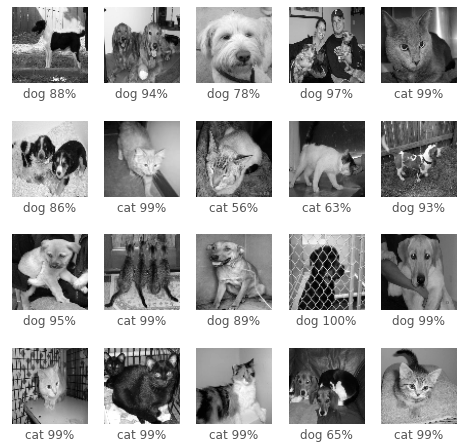

In [ ]:
data1=ypred[1]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data1[i][0]*100))+"%" if data1[i][0] > 0.5 else "cat "+str(int(data1[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold1')
plt.show()

HYPERTUNING 2 CONV + 2 DENSE + DROPOUT + EARLYSTOP

In [ ]:
#definisco l'early stopping per il tuning
from tensorflow.keras.callbacks import EarlyStopping

stop_early=EarlyStopping(
    monitor="val_loss",
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True
)

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.5 MB/s eta 0:00:00


In [ ]:
#definisco l'architettura (HYPERTUNING 2 CONV + 2 DENSE)
def model_builder(hp):
  model = Sequential()
  
  #hp_filters=hp.Int('num_of_filters',min_value=16,max_value=216,step=16)
  hp_filters=hp.Choice('num_of_filters',values=[32,64,128])
  #input layer
  model.add (Conv2D (hp_filters,(3,3), activation='relu',input_shape = X.shape[1:]))
  
  #hidden layer
  model.add (MaxPooling2D (pool_size=(2,2)))
  model.add (Conv2D (hp_filters*2,(3,3), activation='relu'))
  model.add (MaxPooling2D (pool_size=(2,2)))
  model.add (Flatten ())

  hp_dropout=hp.Choice('dropout_value',values=[0.3,0.4,0.5])
  model.add (Dropout (hp_dropout))

  for i in range(hp.Int('num_of_layers',1,3)):
    hp_units=hp.Int('num_of_neurons'+str(i),min_value=32,max_value=512,step=32)
    model.add(Dense(units=hp_units,activation='relu'))
    model.add (Dropout (hp_dropout))

  #output layer
  model.add(Dense(2, activation="softmax"))

  model.compile (
	loss = "categorical_crossentropy",
	optimizer = keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-3,1e-4])),
	metrics = [tf.keras.metrics.CategoricalAccuracy(),custom_zero_loss]
  )

  return model

In [ ]:
#costruisco il tuner
from keras_tuner import BayesianOptimization

tuner=BayesianOptimization(
    model_builder,
    objective='val_categorical_accuracy',
    max_trials=20,
    directory='turner3',
    project_name='ML')

tuner.search_space_summary()

Search space summary
Default search space size: 5
num_of_filters (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
dropout_value (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.4, 0.5], 'ordered': True}
num_of_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
num_of_neurons0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


In [ ]:
#definisco i parametri del tuner
n_epochs=40
n_batch=64

tuner.search(
    x=X,
    y=y,
    validation_split=0.2,
    batch_size = n_batch,
    callbacks=[stop_early],
    epochs=n_epochs
)

bestHP=tuner.get_best_hyperparameters(num_trials=1)[0]
print("[INFO] optimal number of filters: {}".format(
    bestHP.get("num_of_filters")))
for i in range(bestHP.get("num_of_layers")):
  print("[INFO] optimal number of neurons in layer "+str(i+1)+": {}".format(
    bestHP.get("num_of_neurons"+str(i))))
print("[INFO] optimal dropout value: {}".format(
    bestHP.get("dropout_value")))
print("[INFO] optimal learning rate: {}".format(
    bestHP.get("learning_rate")))

Trial 20 Complete [00h 04m 05s]
val_categorical_accuracy: 0.8102204203605652

Best val_categorical_accuracy So Far: 0.8276553153991699
Total elapsed time: 00h 56m 45s
[INFO] optimal number of filters: 128
[INFO] optimal number of neurons in layer 1: 160
[INFO] optimal dropout value: 0.5
[INFO] optimal learning rate: 0.0001


In [ ]:
#definisco l'early stopping per il training
stop_early_test=EarlyStopping(
    monitor="val_categorical_accuracy",
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True
)

In [ ]:
#definisco training e crossvalidation
n_splits=5

def train_and_crossvalidate(X_data,y_data,n_folds=n_splits,batch_size=n_batch):
  scores=[]
  check_pred=[]
  histories=[]
  y_mean_conf=[]

  #cross validation
  kf=KFold(n_folds)

  #splits
  FoldsSetN=0
  for train_index,test_index in kf.split(X_data):
    print('Fold Set #{0}'.format(FoldsSetN))
    X_train, y_train, X_test, y_test = X_data[train_index],y_data[train_index],X_data[test_index],y_data[test_index]

    #model
    model=tuner.hypermodel.build(bestHP)

    #fit
    history = model.fit(X_train,y_train,epochs=n_epochs,batch_size = n_batch,callbacks=[stop_early_test],validation_data=(X_test,y_test))
    histories.append(history)
    save_loss_plot(history,OUTPUT_LOSS_PATH+'#{0}'.format(FoldsSetN))
    save_val_plot(history,OUTPUT_VAL_PATH+'#{0}'.format(FoldsSetN))
    y_conf=model.predict(X_test)
    y_mean_conf.append(y_conf)
    save_conf_plot(y_test,y_conf,OUTPUT_CONF_PATH+'#{0}'.format(FoldsSetN))
    fold_eval=model.evaluate(X_test,y_test)
    print(f'Model Evaluation for fold {FoldsSetN}: Loss {fold_eval[0]} ---- Acc {fold_eval[1]}')

    #zero-one loss
    ypred_test = model.predict (X_test)
    n_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=False)
    p_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=True)
    print(f'Zero-One Loss for fold {FoldsSetN}: {n_zol} n ---- {p_zol} %')

    scores.append({'val_loss':fold_eval[0], 
                   'val_acc':fold_eval[1],
                   'zero_one_n':n_zol,
                   'zero_one_p':p_zol})
    
    #memorizzo i primi 20
    y_check=model.predict (X_data[0:20])
    check_pred.append(y_check)

    #scores check
    #check=model.evaluate(X_test,y_test)
    #print(f'Score for fold {FoldsSetN}: {model.metrics_names[0]} of {check[0]}; {model.metrics_names[1]} of {check[1]*100}%')

    #clear model
    del model
    K.clear_session()
    gc.collect()

    FoldsSetN+=1
  return scores,check_pred,histories,y_mean_conf

Fold Set #0
Epoch 1/40
312/312 [==============================] - 15s 45ms/step - loss: 0.6551 - categorical_accuracy: 0.5954 - custom_zero_loss: 0.4046 - val_loss: 0.6238 - val_categorical_accuracy: 0.6445 - val_custom_zero_loss: 0.3555
Epoch 2/40
312/312 [==============================] - 14s 45ms/step - loss: 0.5647 - categorical_accuracy: 0.7129 - custom_zero_loss: 0.2871 - val_loss: 0.5343 - val_categorical_accuracy: 0.7309 - val_custom_zero_loss: 0.2691
Epoch 3/40
312/312 [==============================] - 14s 45ms/step - loss: 0.5185 - categorical_accuracy: 0.7466 - custom_zero_loss: 0.2533 - val_loss: 0.5056 - val_categorical_accuracy: 0.7547 - val_custom_zero_loss: 0.2453
Epoch 4/40
312/312 [==============================] - 14s 45ms/step - loss: 0.4916 - categorical_accuracy: 0.7636 - custom_zero_loss: 0.2364 - val_loss: 0.4854 - val_categorical_accuracy: 0.7679 - val_custom_zero_loss: 0.2321
Epoch 5/40
312/312 [==============================] - 14s 45ms/step - loss: 0.4724 -

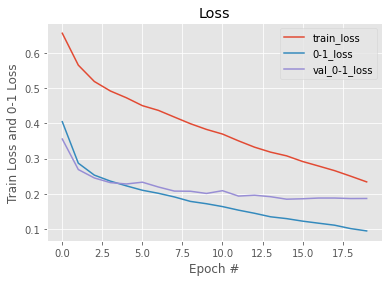

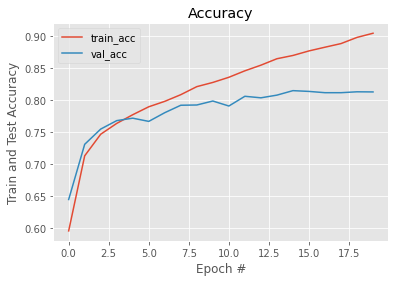

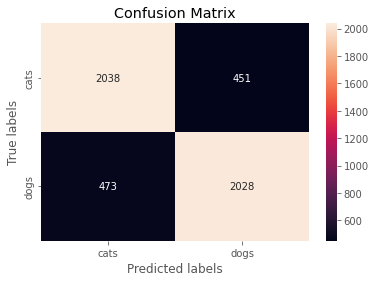

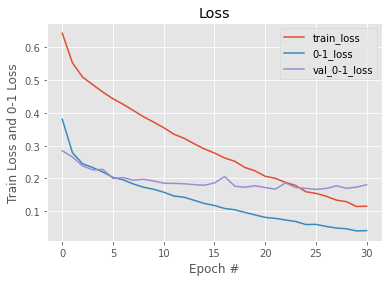

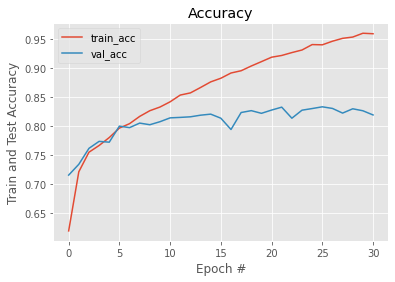

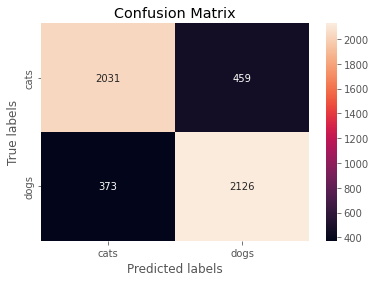

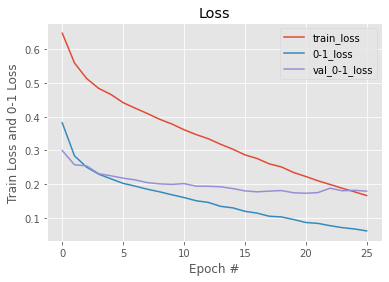

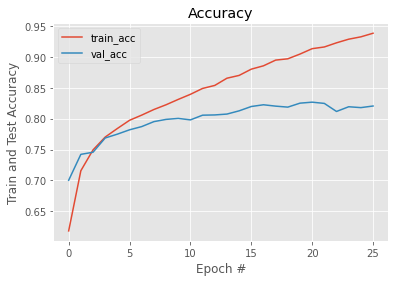

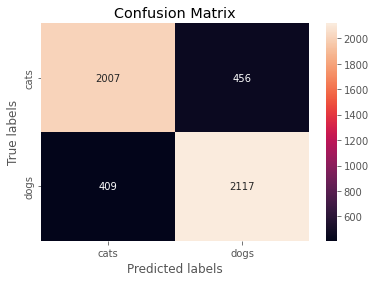

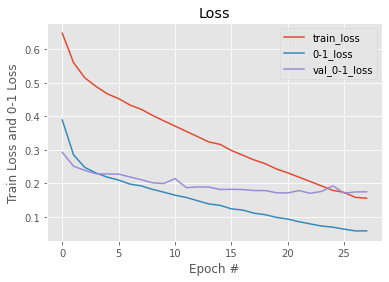

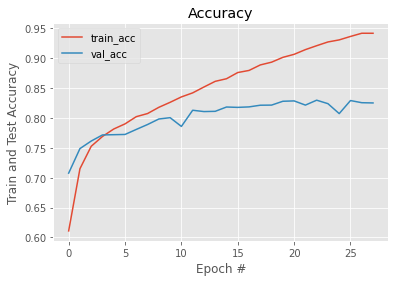

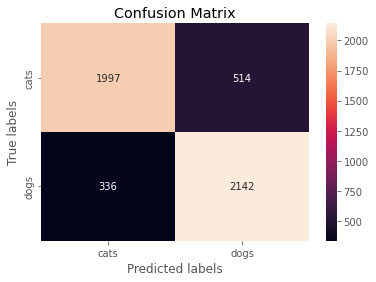

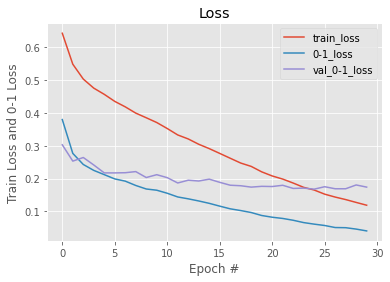

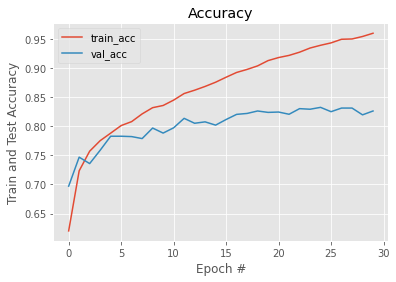

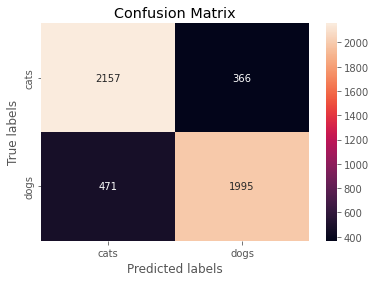

In [ ]:
scores,ypred,histories,y_mean_conf=train_and_crossvalidate(X,y)

In [ ]:
#Print degli scores
val_loss=[]
val_acc=[]
zero_one_N=[]
zero_one_P=[]
for s in scores:
  val_loss.append(s['val_loss'])
  val_acc.append(s['val_acc'])
  zero_one_N.append(s['zero_one_n'])
  zero_one_P.append(s['zero_one_p'])

print('Score per fold')
for i in range(n_splits):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {val_loss[i]} - Accuracy: {val_acc[i]} - Zero-One N Loss: {zero_one_N[i]} - Zero-One Loss: {zero_one_P[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(val_loss)}')
print(f'> Accuracy: {np.mean(val_acc)} (+- {np.std(val_acc)})')
print(f'> Zero-One N Loss: {np.mean(zero_one_N)} (+- {np.std(zero_one_N)})')
print(f'> Zero-One Loss: {np.mean(zero_one_P)} (+- {np.std(zero_one_P)})')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.40738263726234436 - Accuracy: 0.8148296475410461% - Zero-One N Loss: 924 - Zero-One Loss: 0.18517034068136273%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.4237227141857147 - Accuracy: 0.833233118057251% - Zero-One N Loss: 832 - Zero-One Loss: 0.16676688715173382%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.4261104464530945 - Accuracy: 0.8266185522079468% - Zero-One N Loss: 865 - Zero-One Loss: 0.17338143916616555%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.4073713719844818 - Accuracy: 0.8296251893043518% - Zero-One N Loss: 850 - Zero-One Loss: 0.1703748246141511%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.4351350665092468 - Accuracy: 0.8322309255599976% - Zero-One N Loss: 837 - Zero-One Los

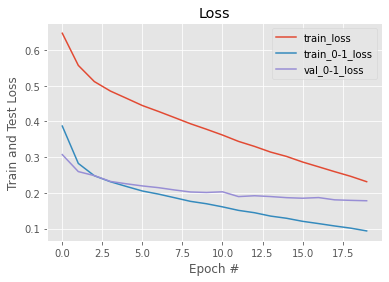

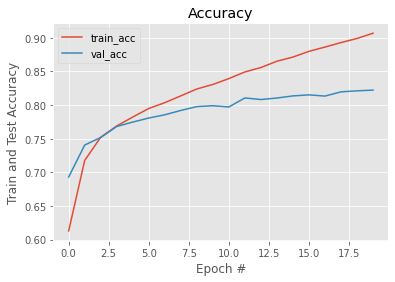

In [ ]:
#costruisco i grafici per la loss e l'accuracy media
mean_loss=np.zeros(n_epochs)
mean_oz_loss=np.zeros(n_epochs)
mean_val_oz_loss=np.zeros(n_epochs)
mean_acc=np.zeros(n_epochs)
mean_val_acc=np.zeros(n_epochs)
min=n_epochs
for h_loss in histories:
  mean_loss = np.add(mean_loss,np.resize(h_loss.history["loss"],(n_epochs,)))
  mean_oz_loss = np.add(mean_oz_loss,np.resize(h_loss.history["custom_zero_loss"],(n_epochs,)))
  mean_val_oz_loss = np.add(mean_val_oz_loss,np.resize(h_loss.history["val_custom_zero_loss"],(n_epochs,)))
  mean_acc= np.add(mean_acc,np.resize(h_loss.history["categorical_accuracy"],(n_epochs,)))
  mean_val_acc = np.add(mean_val_acc,np.resize(h_loss.history["val_categorical_accuracy"],(n_epochs,)))
  if(len(h_loss.history["loss"])<min):
    min=len(h_loss.history["loss"])
mean_loss=np.resize(mean_loss/n_splits,(min,))
mean_oz_loss=np.resize(mean_oz_loss/n_splits,(min,))
mean_val_oz_loss=np.resize(mean_val_oz_loss/n_splits,(min,))
mean_acc=np.resize(mean_acc/n_splits,(min,))
mean_val_acc=np.resize(mean_val_acc/n_splits,(min,))

save_mean_loss_plot(mean_loss,mean_oz_loss,mean_val_oz_loss,OUTPUT_MEAN_LOSS_PATH)
save_mean_acc_plot(mean_acc,mean_val_acc,OUTPUT_MEAN_ACC_PATH)

[[2046.   449.2]
 [ 412.4 2081.6]]


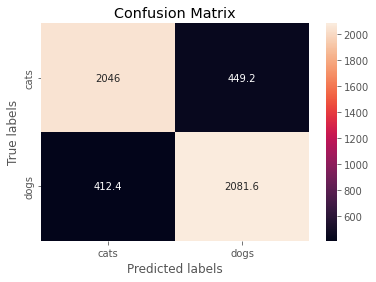

In [ ]:
#costruisco il grafico della matrice di confusione media
ypred_mean=[]
for y_fold in y_mean_conf:
  for y_label in y_fold:
    ypred_mean.append(y_label)
ypred_mean=np.array(ypred_mean)
save_mean_conf_plot(y,ypred_mean,OUTPUT_MEAN_CONF_PATH)

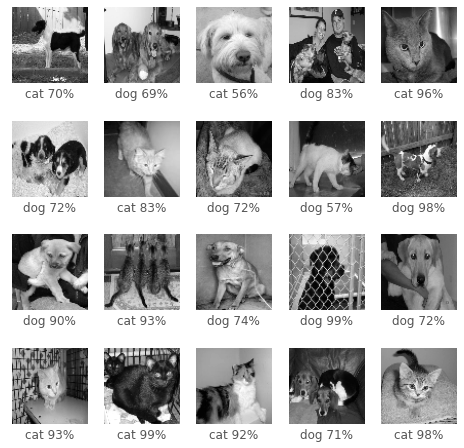

In [ ]:
#[0 1]-> cat,[1 0]->dog
data0=ypred[0]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data0[i][0]*100))+"%" if data0[i][0] > 0.5 else "cat "+str(int(data0[i][1]*100))+"%"}', size=12)
plt.show()

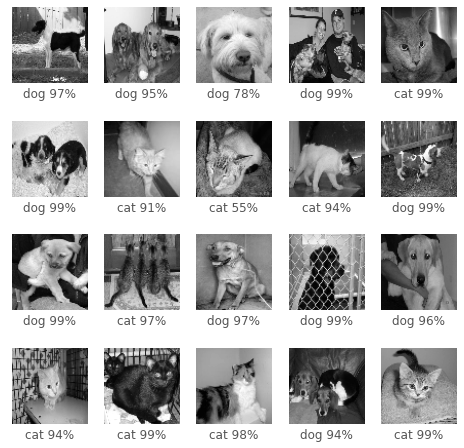

In [ ]:
data1=ypred[1]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data1[i][0]*100))+"%" if data1[i][0] > 0.5 else "cat "+str(int(data1[i][1]*100))+"%"}', size=12)
plt.show()

HYPERTUNING TUTORIAL EXAMPLE + EARLY STOPPING

In [ ]:
#definisco l'early stopping per il tuning
from tensorflow.keras.callbacks import EarlyStopping

stop_early=EarlyStopping(
    monitor="val_loss",
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True
)

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.2 MB/s eta 0:00:00


In [ ]:
#definisco l'architettura (HYPERTUNING 3 CONV)
def model_builder(hp):
  model = Sequential()
  
  hp_filters=hp.Choice('num_of_filters',values=[32,64,128])
  hp_dropout=hp.Choice('dropout_value',values=[0.3,0.4,0.5])
  hp_units=hp.Int('num_of_neurons',min_value=32,max_value=512,step=32)

  #input layer
  model.add (Conv2D (hp_filters,(3,3), activation='relu',input_shape = X.shape[1:]))
  
  #hidden layer
  model.add (MaxPooling2D (pool_size=(2,2)))
  model.add (Conv2D (hp_filters*2,(3,3), activation='relu'))
  model.add (MaxPooling2D (pool_size=(2,2)))
  model.add (Conv2D (hp_filters*2,(3,3), activation='relu'))
  model.add (Flatten ())
  model.add (Dropout (hp_dropout))
  model.add(Dense(units=hp_units,activation='relu'))
  model.add (Dropout (hp_dropout))

  #output layer
  model.add(Dense(2, activation="softmax"))

  model.compile (
	loss = "categorical_crossentropy",
	optimizer = keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-3,1e-4])),
	metrics = [tf.keras.metrics.CategoricalAccuracy(),custom_zero_loss]
  )

  return model

In [ ]:
#costruisco il tuner
from keras_tuner import BayesianOptimization

tuner=BayesianOptimization(
    model_builder,
    objective='val_categorical_accuracy',
    max_trials=20,
    directory='turner3',
    project_name='ML')

tuner.search_space_summary()

Search space summary
Default search space size: 4
num_of_filters (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
dropout_value (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.4, 0.5], 'ordered': True}
num_of_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


In [ ]:
#definisco i parametri del tuner
n_epochs=40
n_batch=64

tuner.search(
    x=X,
    y=y,
    validation_split=0.2,
    batch_size = n_batch,
    callbacks=[stop_early],
    epochs=n_epochs
)

bestHP=tuner.get_best_hyperparameters(num_trials=1)[0]
print("[INFO] optimal number of filters: {}".format(
    bestHP.get("num_of_filters")))
print("[INFO] optimal number of neurons: {}".format(
    bestHP.get("num_of_neurons")))
print("[INFO] optimal dropout value: {}".format(
    bestHP.get("dropout_value")))
print("[INFO] optimal learning rate: {}".format(
    bestHP.get("learning_rate")))

Trial 20 Complete [00h 05m 03s]
val_categorical_accuracy: 0.8575150370597839

Best val_categorical_accuracy So Far: 0.8721442818641663
Total elapsed time: 01h 07m 52s
[INFO] optimal number of filters: 128
[INFO] optimal number of neurons: 256
[INFO] optimal dropout value: 0.5
[INFO] optimal learning rate: 0.001


In [ ]:
#definisco l'early stopping per il training
stop_early_test=EarlyStopping(
    monitor="val_categorical_accuracy",
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True
)

In [ ]:
#definisco training e crossvalidation
n_splits=5

def train_and_crossvalidate(X_data,y_data,n_folds=n_splits,batch_size=n_batch):
  scores=[]
  check_pred=[]
  histories=[]
  y_mean_conf=[]

  #cross validation
  kf=KFold(n_folds)

  #splits
  FoldsSetN=0
  for train_index,test_index in kf.split(X_data):
    print('Fold Set #{0}'.format(FoldsSetN))
    X_train, y_train, X_test, y_test = X_data[train_index],y_data[train_index],X_data[test_index],y_data[test_index]

    #model
    model=tuner.hypermodel.build(bestHP)

    #fit
    history = model.fit(X_train,y_train,epochs=n_epochs,batch_size = n_batch,callbacks=[stop_early_test],validation_data=(X_test,y_test))
    histories.append(history)
    save_loss_plot(history,OUTPUT_LOSS_PATH+'#{0}'.format(FoldsSetN))
    save_val_plot(history,OUTPUT_VAL_PATH+'#{0}'.format(FoldsSetN))
    y_conf=model.predict(X_test)
    y_mean_conf.append(y_conf)
    save_conf_plot(y_test,y_conf,OUTPUT_CONF_PATH+'#{0}'.format(FoldsSetN))
    fold_eval=model.evaluate(X_test,y_test)
    print(f'Model Evaluation for fold {FoldsSetN}: Loss {fold_eval[0]} ---- Acc {fold_eval[1]}')

    #zero-one loss
    ypred_test = model.predict (X_test)
    n_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=False)
    p_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=True)
    print(f'Zero-One Loss for fold {FoldsSetN}: {n_zol} n ---- {p_zol} %')

    scores.append({'val_loss':fold_eval[0], 
                   'val_acc':fold_eval[1],
                   'zero_one_n':n_zol,
                   'zero_one_p':p_zol})
    
    #memorizzo i primi 20
    y_check=model.predict (X_data[0:20])
    check_pred.append(y_check)

    #scores check
    #check=model.evaluate(X_test,y_test)
    #print(f'Score for fold {FoldsSetN}: {model.metrics_names[0]} of {check[0]}; {model.metrics_names[1]} of {check[1]*100}%')

    #clear model
    del model
    K.clear_session()
    gc.collect()

    FoldsSetN+=1
  return scores,check_pred,histories,y_mean_conf

Fold Set #0
Epoch 1/40
312/312 [==============================] - 19s 51ms/step - loss: 0.6921 - categorical_accuracy: 0.5410 - custom_zero_loss: 0.4589 - val_loss: 0.6669 - val_categorical_accuracy: 0.5840 - val_custom_zero_loss: 0.4160
Epoch 2/40
312/312 [==============================] - 15s 47ms/step - loss: 0.6429 - categorical_accuracy: 0.6286 - custom_zero_loss: 0.3713 - val_loss: 0.6090 - val_categorical_accuracy: 0.6645 - val_custom_zero_loss: 0.3354
Epoch 3/40
312/312 [==============================] - 15s 47ms/step - loss: 0.5546 - categorical_accuracy: 0.7133 - custom_zero_loss: 0.2866 - val_loss: 0.4816 - val_categorical_accuracy: 0.7673 - val_custom_zero_loss: 0.2327
Epoch 4/40
312/312 [==============================] - 14s 46ms/step - loss: 0.4786 - categorical_accuracy: 0.7713 - custom_zero_loss: 0.2287 - val_loss: 0.4520 - val_categorical_accuracy: 0.7842 - val_custom_zero_loss: 0.2158
Epoch 5/40
312/312 [==============================] - 14s 46ms/step - loss: 0.4261 -

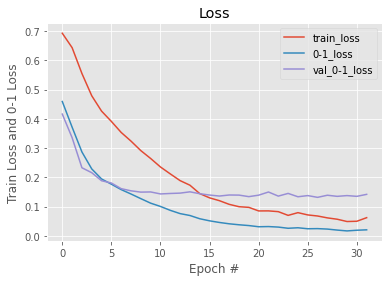

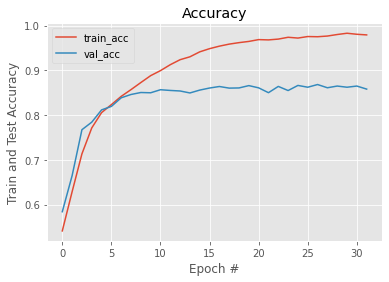

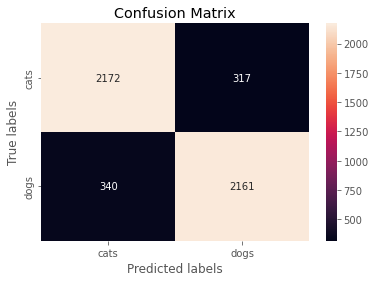

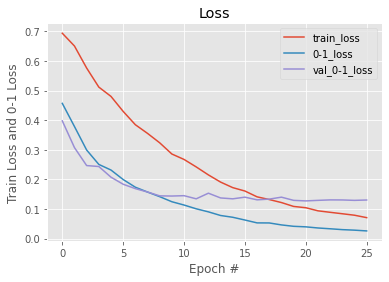

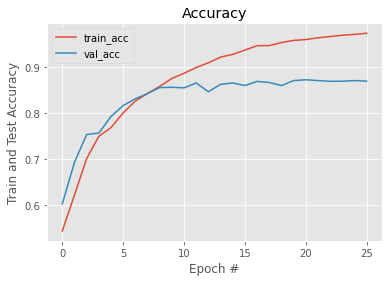

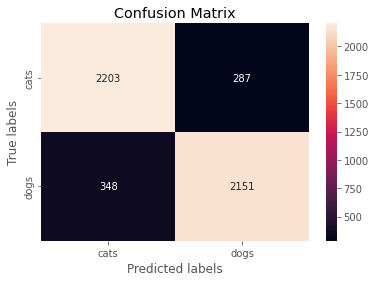

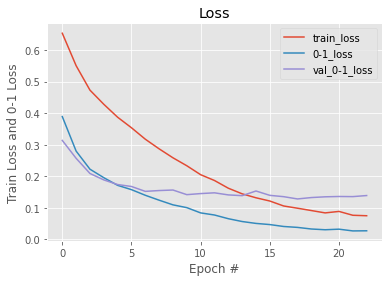

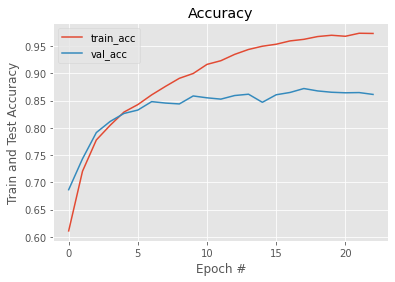

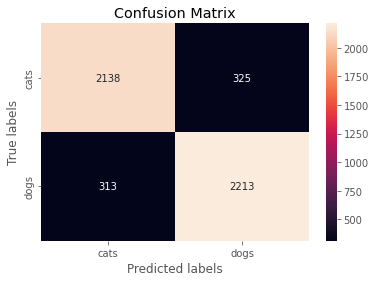

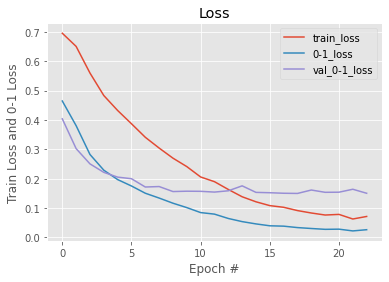

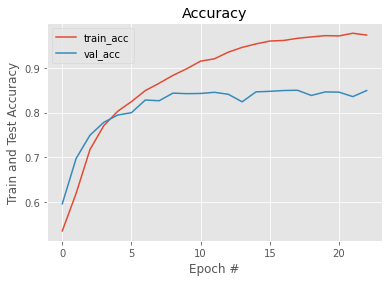

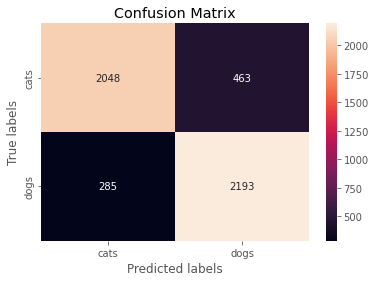

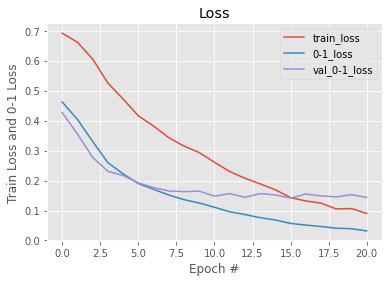

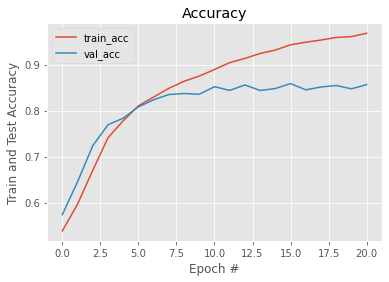

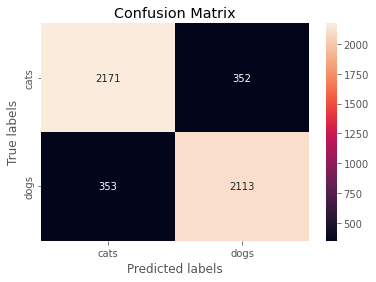

In [ ]:
scores,ypred,histories,y_mean_conf=train_and_crossvalidate(X,y)

In [ ]:
#Print degli scores
val_loss=[]
val_acc=[]
zero_one_N=[]
zero_one_P=[]
for s in scores:
  val_loss.append(s['val_loss'])
  val_acc.append(s['val_acc'])
  zero_one_N.append(s['zero_one_n'])
  zero_one_P.append(s['zero_one_p'])

print('Score per fold')
for i in range(n_splits):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {val_loss[i]} - Accuracy: {val_acc[i]} - Zero-One N Loss: {zero_one_N[i]} - Zero-One Loss: {zero_one_P[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(val_loss)}')
print(f'> Accuracy: {np.mean(val_acc)} (+- {np.std(val_acc)})')
print(f'> Zero-One N Loss: {np.mean(zero_one_N)} (+- {np.std(zero_one_N)})')
print(f'> Zero-One Loss: {np.mean(zero_one_P)} (+- {np.std(zero_one_P)})')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.48097488284111023 - Accuracy: 0.8683366775512695 - Zero-One N Loss: 657 - Zero-One Loss: 0.1316633266533066
------------------------------------------------------------------------
> Fold 2 - Loss: 0.36144962906837463 - Accuracy: 0.8727200031280518 - Zero-One N Loss: 635 - Zero-One Loss: 0.1272800160352776
------------------------------------------------------------------------
> Fold 3 - Loss: 0.4125235676765442 - Accuracy: 0.8721186518669128 - Zero-One N Loss: 638 - Zero-One Loss: 0.12788133894568054
------------------------------------------------------------------------
> Fold 4 - Loss: 0.44083479046821594 - Accuracy: 0.8500701785087585 - Zero-One N Loss: 748 - Zero-One Loss: 0.14992984566045298
------------------------------------------------------------------------
> Fold 5 - Loss: 0.39629024267196655 - Accuracy: 0.8586891293525696 - Zero-One N Loss: 705 - Zero-One Loss: 0.1

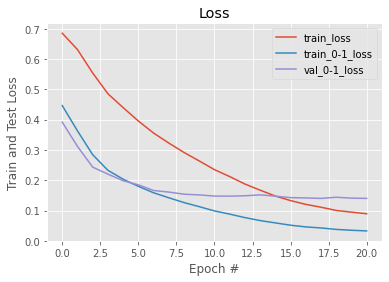

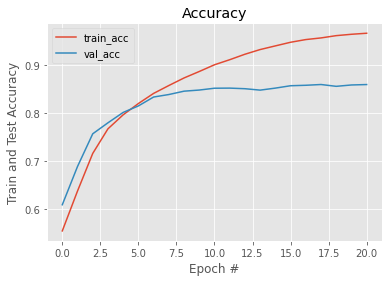

In [ ]:
#costruisco i grafici per la loss e l'accuracy media
mean_loss=np.zeros(n_epochs)
mean_oz_loss=np.zeros(n_epochs)
mean_val_oz_loss=np.zeros(n_epochs)
mean_acc=np.zeros(n_epochs)
mean_val_acc=np.zeros(n_epochs)
min=n_epochs
for h_loss in histories:
  mean_loss = np.add(mean_loss,np.resize(h_loss.history["loss"],(n_epochs,)))
  mean_oz_loss = np.add(mean_oz_loss,np.resize(h_loss.history["custom_zero_loss"],(n_epochs,)))
  mean_val_oz_loss = np.add(mean_val_oz_loss,np.resize(h_loss.history["val_custom_zero_loss"],(n_epochs,)))
  mean_acc= np.add(mean_acc,np.resize(h_loss.history["categorical_accuracy"],(n_epochs,)))
  mean_val_acc = np.add(mean_val_acc,np.resize(h_loss.history["val_categorical_accuracy"],(n_epochs,)))
  if(len(h_loss.history["loss"])<min):
    min=len(h_loss.history["loss"])
mean_loss=np.resize(mean_loss/n_splits,(min,))
mean_oz_loss=np.resize(mean_oz_loss/n_splits,(min,))
mean_val_oz_loss=np.resize(mean_val_oz_loss/n_splits,(min,))
mean_acc=np.resize(mean_acc/n_splits,(min,))
mean_val_acc=np.resize(mean_val_acc/n_splits,(min,))

save_mean_loss_plot(mean_loss,mean_oz_loss,mean_val_oz_loss,OUTPUT_MEAN_LOSS_PATH)
save_mean_acc_plot(mean_acc,mean_val_acc,OUTPUT_MEAN_ACC_PATH)

[[2146.4  348.8]
 [ 327.8 2166.2]]


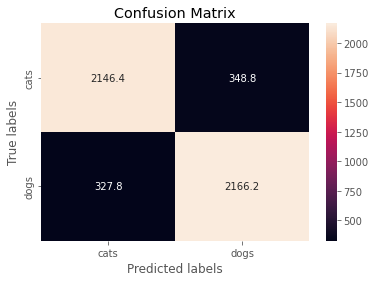

In [ ]:
#costruisco il grafico della matrice di confusione media
ypred_mean=[]
for y_fold in y_mean_conf:
  for y_label in y_fold:
    ypred_mean.append(y_label)
ypred_mean=np.array(ypred_mean)
save_mean_conf_plot(y,ypred_mean,OUTPUT_MEAN_CONF_PATH)

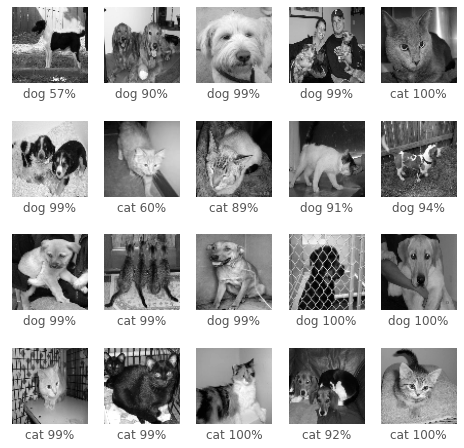

In [ ]:
#[0 1]-> cat,[1 0]->dog
data0=ypred[0]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data0[i][0]*100))+"%" if data0[i][0] > 0.5 else "cat "+str(int(data0[i][1]*100))+"%"}', size=12)
plt.show()

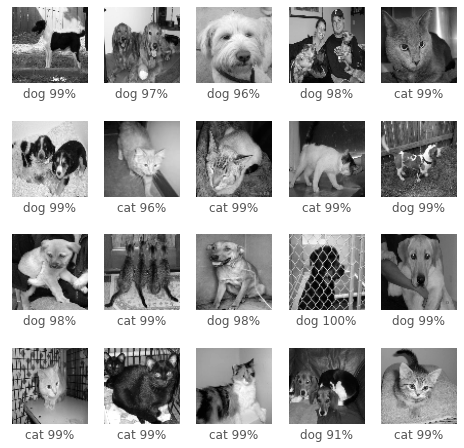

In [ ]:
data1=ypred[1]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data1[i][0]*100))+"%" if data1[i][0] > 0.5 else "cat "+str(int(data1[i][1]*100))+"%"}', size=12)
plt.show()

HYPERTUNING N CONV + M DENSE + DROPOUT + EARLYSTOP

In [ ]:
#definisco l'early stopping per il tuning
from tensorflow.keras.callbacks import EarlyStopping

stop_early=EarlyStopping(
    monitor="val_loss",
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True
)

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.9 MB/s eta 0:00:00


In [ ]:
#definisco l'architettura (HYPER N CONV LAYER)
def model_builder(hp):
  model = Sequential()
  
  #hp_filters=hp.Int('num_of_filters',min_value=16,max_value=216,step=16)
  hp_filters=hp.Choice('num_of_filters',values=[32,64])
  for i in range(hp.Int('num_of_conv_layers',2,5)):
    model.add (Conv2D (min(hp_filters*pow(2,i),512),(3,3), activation='relu',input_shape = X.shape[1:]))
    model.add (MaxPooling2D (pool_size=(2,2)))

  model.add (Flatten ())

  hp_dropout=hp.Choice('dropout_value',values=[0.4,0.5])
  model.add (Dropout (hp_dropout))

  hp_units=hp.Choice('num_of_neurons',values=[64,128])
  hp_nlayers=hp.Int('num_of_layers',1,3)
  for i in range(hp_nlayers):
    model.add(Dense(units=hp_units*pow(2,hp_nlayers-1-i),activation='relu'))
    model.add (Dropout (hp_dropout))

  #output layer
  model.add(Dense(2, activation="softmax"))

  model.compile (
	loss = "categorical_crossentropy",
	optimizer = keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-3,1e-4])),
	metrics = [tf.keras.metrics.CategoricalAccuracy(),custom_zero_loss]
  )

  return model

In [ ]:
#aggiungere model.summary dopo tuning per la stampa

In [ ]:
#costruisco il tuner
from keras_tuner import BayesianOptimization

tuner=BayesianOptimization(
    model_builder,
    objective='val_categorical_accuracy',
    max_trials=20,
    directory='turner4',
    project_name='ML')

tuner.search_space_summary()

Search space summary
Default search space size: 6
num_of_filters (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64], 'ordered': True}
num_of_conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
dropout_value (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.4, 0.5], 'ordered': True}
num_of_neurons (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
num_of_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


In [ ]:
#definisco i parametri del tuner
n_epochs=40
n_batch=64

tuner.search(
    x=X,
    y=y,
    validation_split=0.2,
    batch_size = n_batch,
    callbacks=[stop_early],
    epochs=n_epochs
)

bestHP=tuner.get_best_hyperparameters(num_trials=1)[0]
print("[INFO] optimal number of starting filters: {}".format(
    bestHP.get("num_of_filters")))
print("[INFO] optimal number of conv layers: {}".format(
    bestHP.get("num_of_conv_layers")))
print("[INFO] optimal dropout value: {}".format(
    bestHP.get("dropout_value")))
print("[INFO] optimal number of last dense layer neurons: {}".format(
    bestHP.get("num_of_neurons")))
print("[INFO] optimal number of dense layers: {}".format(
    bestHP.get("num_of_layers")))
print("[INFO] optimal learning rate: {}".format(
    bestHP.get("learning_rate")))

Trial 20 Complete [00h 00m 49s]

Best val_categorical_accuracy So Far: 0.8825651407241821
Total elapsed time: 00h 42m 55s
[INFO] optimal number of starting filters: 32
[INFO] optimal number of conv layers: 3
[INFO] optimal dropout value: 0.4
[INFO] optimal number of last dense layer neurons: 128
[INFO] optimal number of dense layers: 1
[INFO] optimal learning rate: 0.001


In [ ]:
#definisco l'early stopping per il training
stop_early_test=EarlyStopping(
    monitor="val_categorical_accuracy",
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True
)

In [ ]:
#definisco training e crossvalidation
n_splits=5

def train_and_crossvalidate(X_data,y_data,n_folds=n_splits,batch_size=n_batch):
  scores=[]
  check_pred=[]
  histories=[]
  y_mean_conf=[]

  #cross validation
  kf=KFold(n_folds)

  #splits
  FoldsSetN=0
  for train_index,test_index in kf.split(X_data):
    print('Fold Set #{0}'.format(FoldsSetN))
    X_train, y_train, X_test, y_test = X_data[train_index],y_data[train_index],X_data[test_index],y_data[test_index]

    #model
    model=tuner.hypermodel.build(bestHP)

    #fit
    history = model.fit(X_train,y_train,epochs=n_epochs,batch_size = n_batch,callbacks=[stop_early_test],validation_data=(X_test,y_test))
    histories.append(history)
    save_loss_plot(history,OUTPUT_LOSS_PATH+'#{0}'.format(FoldsSetN))
    save_val_plot(history,OUTPUT_VAL_PATH+'#{0}'.format(FoldsSetN))
    y_conf=model.predict(X_test)
    y_mean_conf.append(y_conf)
    save_conf_plot(y_test,y_conf,OUTPUT_CONF_PATH+'#{0}'.format(FoldsSetN))
    fold_eval=model.evaluate(X_test,y_test)
    print(f'Model Evaluation for fold {FoldsSetN}: Loss {fold_eval[0]} ---- Acc {fold_eval[1]}')

    #zero-one loss
    ypred_test = model.predict (X_test)
    n_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=False)
    p_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=True)
    print(f'Zero-One Loss for fold {FoldsSetN}: {n_zol} n ---- {p_zol} %')

    scores.append({'val_loss':fold_eval[0], 
                   'val_acc':fold_eval[1],
                   'zero_one_n':n_zol,
                   'zero_one_p':p_zol})
    
    #memorizzo i primi 20
    y_check=model.predict (X_data[0:20])
    check_pred.append(y_check)

    #scores check
    #check=model.evaluate(X_test,y_test)
    #print(f'Score for fold {FoldsSetN}: {model.metrics_names[0]} of {check[0]}; {model.metrics_names[1]} of {check[1]*100}%')

    #clear model
    del model
    K.clear_session()
    gc.collect()

    FoldsSetN+=1
  return scores,check_pred,histories,y_mean_conf

Fold Set #0
Epoch 1/40
312/312 [==============================] - 6s 17ms/step - loss: 0.6482 - categorical_accuracy: 0.6146 - custom_zero_loss: 0.3853 - val_loss: 0.5810 - val_categorical_accuracy: 0.6896 - val_custom_zero_loss: 0.3104
Epoch 2/40
312/312 [==============================] - 5s 16ms/step - loss: 0.5365 - categorical_accuracy: 0.7342 - custom_zero_loss: 0.2658 - val_loss: 0.4722 - val_categorical_accuracy: 0.7772 - val_custom_zero_loss: 0.2228
Epoch 3/40
312/312 [==============================] - 5s 16ms/step - loss: 0.4662 - categorical_accuracy: 0.7785 - custom_zero_loss: 0.2216 - val_loss: 0.4530 - val_categorical_accuracy: 0.7774 - val_custom_zero_loss: 0.2227
Epoch 4/40
312/312 [==============================] - 5s 16ms/step - loss: 0.4258 - categorical_accuracy: 0.8049 - custom_zero_loss: 0.1951 - val_loss: 0.3980 - val_categorical_accuracy: 0.8164 - val_custom_zero_loss: 0.1836
Epoch 5/40
312/312 [==============================] - 5s 16ms/step - loss: 0.3885 - cate

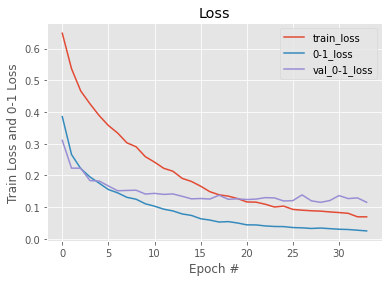

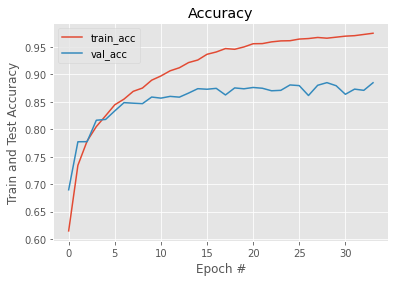

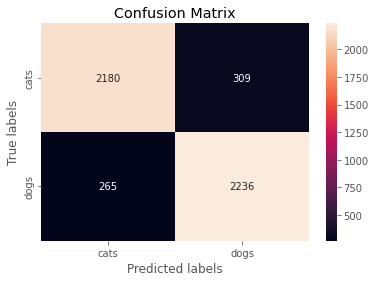

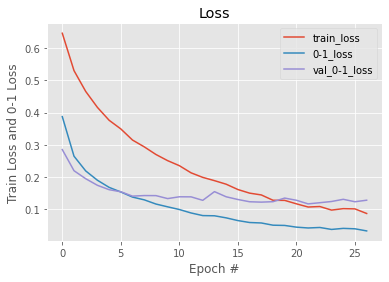

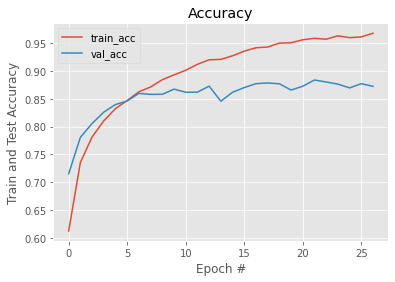

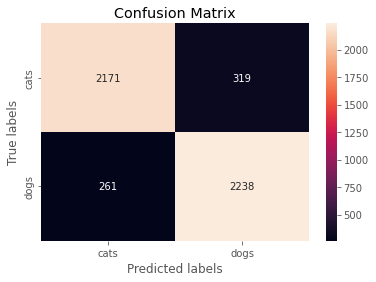

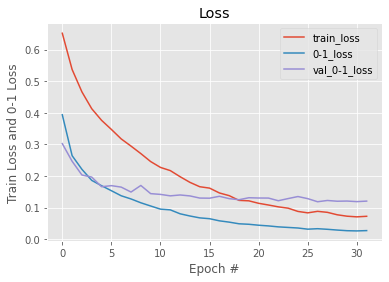

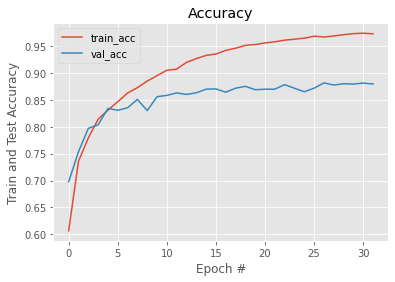

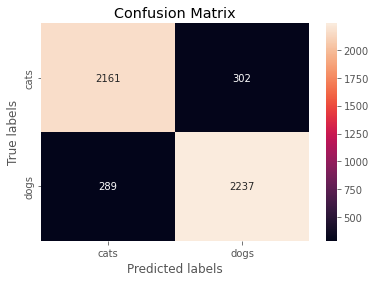

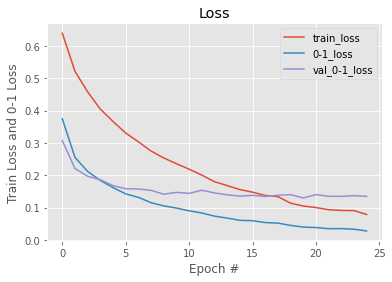

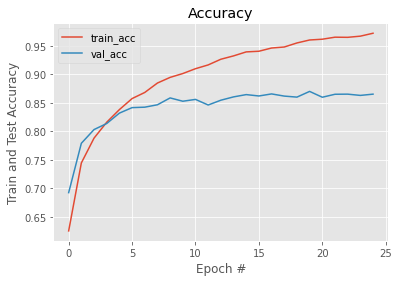

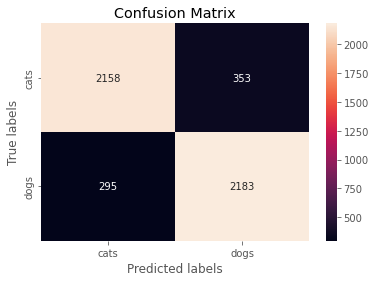

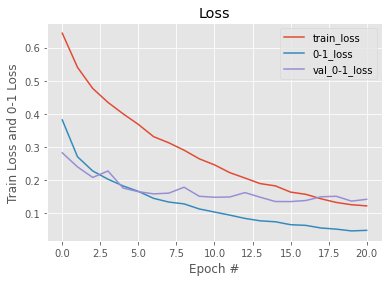

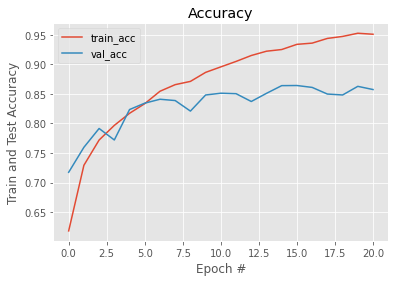

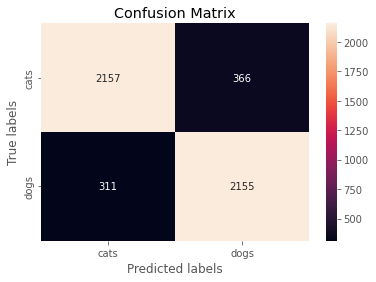

In [ ]:
scores,ypred,histories,y_mean_conf=train_and_crossvalidate(X,y)

In [ ]:
#Print degli scores
val_loss=[]
val_acc=[]
zero_one_N=[]
zero_one_P=[]
for s in scores:
  val_loss.append(s['val_loss'])
  val_acc.append(s['val_acc'])
  zero_one_N.append(s['zero_one_n'])
  zero_one_P.append(s['zero_one_p'])

print('Score per fold')
for i in range(n_splits):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {val_loss[i]} - Accuracy: {val_acc[i]}% - Zero-One N Loss: {zero_one_N[i]} - Zero-One Loss: {zero_one_P[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(val_loss)}')
print(f'> Accuracy: {np.mean(val_acc)}% (+- {np.std(val_acc)})')
print(f'> Zero-One N Loss: {np.mean(zero_one_N)} (+- {np.std(zero_one_N)})')
print(f'> Zero-One Loss: {np.mean(zero_one_P)}% (+- {np.std(zero_one_P)})')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.3429076671600342 - Accuracy: 0.88496994972229% - Zero-One N Loss: 574 - Zero-One Loss: 0.11503006012024053%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.36528536677360535 - Accuracy: 0.8837442398071289% - Zero-One N Loss: 580 - Zero-One Loss: 0.1162557626778914%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.38053494691848755 - Accuracy: 0.8815394043922424% - Zero-One N Loss: 591 - Zero-One Loss: 0.11846061334936864%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.38060012459754944 - Accuracy: 0.870114266872406% - Zero-One N Loss: 648 - Zero-One Loss: 0.1298857486470234%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.35571345686912537 - Accuracy: 0.8643014430999756% - Zero-One N Loss: 677 - Zero-One Los

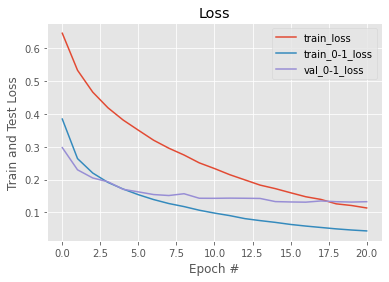

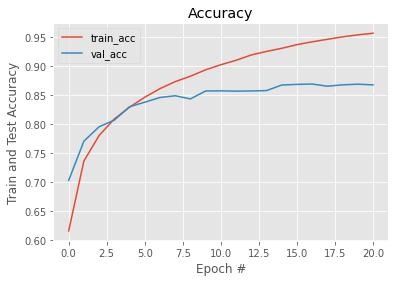

In [ ]:
#costruisco i grafici per la loss e l'accuracy media
mean_loss=np.zeros(n_epochs)
mean_oz_loss=np.zeros(n_epochs)
mean_val_oz_loss=np.zeros(n_epochs)
mean_acc=np.zeros(n_epochs)
mean_val_acc=np.zeros(n_epochs)
min=n_epochs
for h_loss in histories:
  mean_loss = np.add(mean_loss,np.resize(h_loss.history["loss"],(40,)))
  mean_oz_loss = np.add(mean_oz_loss,np.resize(h_loss.history["custom_zero_loss"],(40,)))
  mean_val_oz_loss = np.add(mean_val_oz_loss,np.resize(h_loss.history["val_custom_zero_loss"],(40,)))
  mean_acc= np.add(mean_acc,np.resize(h_loss.history["categorical_accuracy"],(40,)))
  mean_val_acc = np.add(mean_val_acc,np.resize(h_loss.history["val_categorical_accuracy"],(40,)))
  if(len(h_loss.history["loss"])<min):
    min=len(h_loss.history["loss"])
mean_loss=np.resize(mean_loss/n_splits,(min,))
mean_oz_loss=np.resize(mean_oz_loss/n_splits,(min,))
mean_val_oz_loss=np.resize(mean_val_oz_loss/n_splits,(min,))
mean_acc=np.resize(mean_acc/n_splits,(min,))
mean_val_acc=np.resize(mean_val_acc/n_splits,(min,))

save_mean_loss_plot(mean_loss,mean_oz_loss,mean_val_oz_loss,OUTPUT_MEAN_LOSS_PATH)
save_mean_acc_plot(mean_acc,mean_val_acc,OUTPUT_MEAN_ACC_PATH)

[[2165.4  329.8]
 [ 284.2 2209.8]]


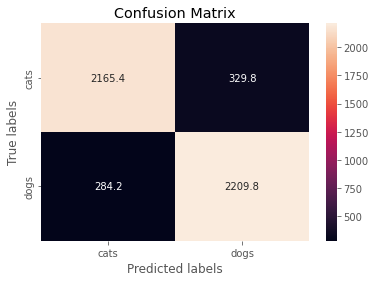

In [ ]:
#costruisco il grafico della matrice di confusione media
ypred_mean=[]
for y_fold in y_mean_conf:
  for y_label in y_fold:
    ypred_mean.append(y_label)
ypred_mean=np.array(ypred_mean)
save_mean_conf_plot(y,ypred_mean,OUTPUT_MEAN_CONF_PATH)

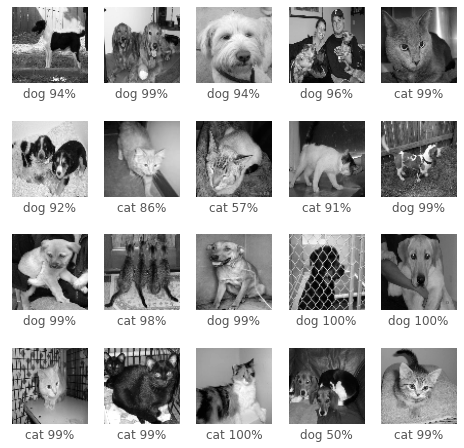

In [ ]:
#[0 1]-> cat,[1 0]->dog
data0=ypred[0]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data0[i][0]*100))+"%" if data0[i][0] > 0.5 else "cat "+str(int(data0[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold0')
plt.show()

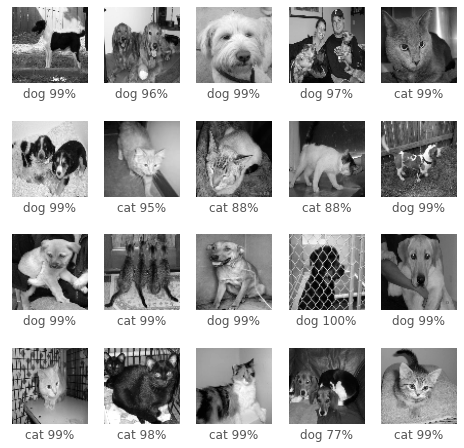

In [ ]:
data1=ypred[1]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data1[i][0]*100))+"%" if data1[i][0] > 0.5 else "cat "+str(int(data1[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold1')
plt.show()

In [ ]:
def model_stamp():
  model = Sequential()
  
  #hp_filters=hp.Int('num_of_filters',min_value=16,max_value=216,step=16)
  model.add (Conv2D (32,(3,3), activation='relu',input_shape = X.shape[1:]))
  model.add (MaxPooling2D (pool_size=(2,2)))
  model.add (Conv2D (64,(3,3), activation='relu'))
  model.add (MaxPooling2D (pool_size=(2,2)))
  model.add (Conv2D (128,(3,3), activation='relu'))
  model.add (MaxPooling2D (pool_size=(2,2)))
  model.add (Flatten ())

  model.add (Dropout (0.4))

  model.add(Dense(units=128,activation='relu'))
  model.add (Dropout (0.4))

  #output layer
  model.add(Dense(2, activation="softmax"))

  model.compile (
	loss = "categorical_crossentropy",
	optimizer = keras.optimizers.Adam(0.001),
	metrics = [tf.keras.metrics.CategoricalAccuracy(),custom_zero_loss]
  )

  return model

In [ ]:
model=model_stamp()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 128)        0

HYPERTUNING TUTORIAL M CONV N DENSE

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

stop_early=EarlyStopping(
    monitor="val_loss",
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True
)

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.3 MB/s eta 0:00:00


In [ ]:
def model_builder(hp):
  model = Sequential()
  
  #hp_filters=hp.Int('num_of_filters',min_value=16,max_value=216,step=16)
  hp_filters=hp.Choice('num_of_filters',values=[32,64])
  hp_nConv=hp.Int('num_of_conv_layers',2,5)
  for i in range(hp_nConv):
    if(i==0):
      model.add (Conv2D (min(hp_filters*pow(2,i),512),(3,3), activation='relu',input_shape = X.shape[1:]))
    else:
      model.add (Conv2D (min(hp_filters*pow(2,i),512),(3,3), activation='relu'))
    model.add (MaxPooling2D (pool_size=(2,2)))

  model.add (Conv2D (min(hp_filters*pow(2,hp_nConv),512),(3,3), activation='relu'))
  model.add (Flatten ())

  hp_dropout=hp.Choice('dropout_value',values=[0.4,0.5])
  model.add (Dropout (hp_dropout))

  hp_units=hp.Choice('num_of_neurons',values=[64,128])
  hp_nlayers=hp.Int('num_of_layers',1,3)
  for i in range(hp_nlayers):
    model.add(Dense(units=hp_units*pow(2,hp_nlayers-1-i),activation='relu'))
    model.add (Dropout (hp_dropout))

  #output layer
  model.add(Dense(2, activation="softmax"))

  model.compile (
	loss = "categorical_crossentropy",
	optimizer = "adam",
	metrics = [tf.keras.metrics.CategoricalAccuracy(),custom_zero_loss]
  )

  return model

In [ ]:
from keras_tuner import BayesianOptimization

tuner=BayesianOptimization(
    model_builder,
    objective='val_categorical_accuracy',
    max_trials=20,
    directory='turner4',
    project_name='ML')

tuner.search_space_summary()

Search space summary
Default search space size: 5
num_of_filters (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64], 'ordered': True}
num_of_conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
dropout_value (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.4, 0.5], 'ordered': True}
num_of_neurons (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
num_of_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}


In [ ]:
#HYPER N LAYERS
n_epochs=40
n_batch=64

tuner.search(
    x=X,
    y=y,
    validation_split=0.2,
    batch_size = n_batch,
    callbacks=[stop_early],
    epochs=n_epochs
)

bestHP=tuner.get_best_hyperparameters(num_trials=1)[0]
print("[INFO] optimal number of starting filters: {}".format(
    bestHP.get("num_of_filters")))
print("[INFO] optimal number of conv layers: {}".format(
    bestHP.get("num_of_conv_layers")))
print("[INFO] optimal dropout value: {}".format(
    bestHP.get("dropout_value")))
print("[INFO] optimal number of last dense layer neurons: {}".format(
    bestHP.get("num_of_neurons")))
print("[INFO] optimal number of dense layers: {}".format(
    bestHP.get("num_of_layers")))
print("[INFO] optimal learning rate: {}".format(
    bestHP.get("learning_rate")))

Trial 15 Complete [00h 00m 00s]

Best val_categorical_accuracy So Far: 0.8739479184150696
Total elapsed time: 00h 14m 00s

Search: Running Trial #16

Value             |Best Value So Far |Hyperparameter
64                |64                |num_of_filters
5                 |3                 |num_of_conv_layers
0.4               |0.5               |dropout_value
64                |64                |num_of_neurons
2                 |1                 |num_of_layers



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/keras_tuner/engine/base_tuner.py", line 250, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras_tuner/engine/base_tuner.py", line 215, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras_tuner/engine/tuner.py", line 286, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras_tuner/engine/tuner.py", line 212, in _build_and_fit_model
    model = self._try_build(hp)
  File "/usr/local/lib/python3.8/dist-packages/keras_tuner/engine/tuner.py", line 154, in _try_build
    model = self._build_hypermodel(hp)
  File "/usr/local/lib/python3.8/dist-packages/keras_tuner/engine/tuner.py", line 145, in _build_hypermodel
    model = self.hypermodel.build(hp)
 

RuntimeError: ignored

In [ ]:
stop_early_test=EarlyStopping(
    monitor="val_categorical_accuracy",
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True
)

In [ ]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_categorical_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

In [ ]:
n_splits=5

def train_and_crossvalidate(X_data,y_data,n_folds=n_splits,batch_size=n_batch):
  scores=[]
  check_pred=[]
  histories=[]
  y_mean_conf=[]

  #prepare cross validation
  kf=KFold(n_folds)

  #enumerate splits
  FoldsSetN=0
  for train_index,test_index in kf.split(X_data):
    print('Fold Set #{0}'.format(FoldsSetN))
    X_train, y_train, X_test, y_test = X_data[train_index],y_data[train_index],X_data[test_index],y_data[test_index]

    #create the model
    model=tuner.hypermodel.build(bestHP)

    #fit the model
    history = model.fit(X_train,y_train,epochs=n_epochs,batch_size = n_batch,callbacks=[stop_early_test,learning_rate_reduction],validation_data=(X_test,y_test))
    histories.append(history)
    save_loss_plot(history,OUTPUT_LOSS_PATH+'#{0}'.format(FoldsSetN))
    save_val_plot(history,OUTPUT_VAL_PATH+'#{0}'.format(FoldsSetN))
    y_conf=model.predict(X_test)
    y_mean_conf.append(y_conf)
    save_conf_plot(y_test,y_conf,OUTPUT_CONF_PATH+'#{0}'.format(FoldsSetN))
    fold_eval=model.evaluate(X_test,y_test)
    print(f'Model Evaluation for fold {FoldsSetN}: Loss {fold_eval[0]} ---- Acc {fold_eval[1]}')

    #zero-one loss
    ypred_test = model.predict (X_test)
    n_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=False)
    p_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=True)
    print(f'Zero-One Loss for fold {FoldsSetN}: {n_zol} n ---- {p_zol} %')

    scores.append({'val_loss':fold_eval[0], 
                   'val_acc':fold_eval[1],
                   'zero_one_n':n_zol,
                   'zero_one_p':p_zol})
    
    #memorize first 20
    y_check=model.predict (X_data[0:20])
    check_pred.append(y_check)

    #scores check
    #check=model.evaluate(X_test,y_test)
    #print(f'Score for fold {FoldsSetN}: {model.metrics_names[0]} of {check[0]}; {model.metrics_names[1]} of {check[1]*100}%')

    #clear model
    del model
    K.clear_session()
    gc.collect()

    FoldsSetN+=1
  return scores,check_pred,histories,y_mean_conf

In [ ]:
scores,ypred,histories,y_mean_conf=train_and_crossvalidate(X,y)

Fold Set #0


ValueError: ignored

In [ ]:
#Provide scores
val_loss=[]
val_acc=[]
zero_one_N=[]
zero_one_P=[]
for s in scores:
  val_loss.append(s['val_loss'])
  val_acc.append(s['val_acc'])
  zero_one_N.append(s['zero_one_n'])
  zero_one_P.append(s['zero_one_p'])

print('Score per fold')
for i in range(n_splits):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {val_loss[i]} - Accuracy: {val_acc[i]} - Zero-One N Loss: {zero_one_N[i]} - Zero-One Loss: {zero_one_P[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(val_loss)}')
print(f'> Accuracy: {np.mean(val_acc)} (+- {np.std(val_acc)})')
print(f'> Zero-One N Loss: {np.mean(zero_one_N)} (+- {np.std(zero_one_N)})')
print(f'> Zero-One Loss: {np.mean(zero_one_P)} (+- {np.std(zero_one_P)})')

In [ ]:
#costruisco i grafici per la loss e l'accuracy media
mean_loss=np.zeros(n_epochs)
mean_oz_loss=np.zeros(n_epochs)
mean_val_oz_loss=np.zeros(n_epochs)
mean_acc=np.zeros(n_epochs)
mean_val_acc=np.zeros(n_epochs)
min=n_epochs
for h_loss in histories:
  mean_loss = np.add(mean_loss,np.resize(h_loss.history["loss"],(40,)))
  mean_oz_loss = np.add(mean_oz_loss,np.resize(h_loss.history["custom_zero_loss"],(40,)))
  mean_val_oz_loss = np.add(mean_val_oz_loss,np.resize(h_loss.history["val_custom_zero_loss"],(40,)))
  mean_acc= np.add(mean_acc,np.resize(h_loss.history["categorical_accuracy"],(40,)))
  mean_val_acc = np.add(mean_val_acc,np.resize(h_loss.history["val_categorical_accuracy"],(40,)))
  if(len(h_loss.history["loss"])<min):
    min=len(h_loss.history["loss"])
mean_loss=np.resize(mean_loss/n_splits,(min,))
mean_oz_loss=np.resize(mean_oz_loss/n_splits,(min,))
mean_val_oz_loss=np.resize(mean_val_oz_loss/n_splits,(min,))
mean_acc=np.resize(mean_acc/n_splits,(min,))
mean_val_acc=np.resize(mean_val_acc/n_splits,(min,))

save_mean_loss_plot(mean_loss,mean_oz_loss,mean_val_oz_loss,OUTPUT_MEAN_LOSS_PATH)
save_mean_acc_plot(mean_acc,mean_val_acc,OUTPUT_MEAN_ACC_PATH)

In [ ]:
#costruisco il grafico della matrice di confusione media
ypred_mean=[]
for y_fold in y_mean_conf:
  for y_label in y_fold:
    ypred_mean.append(y_label)
ypred_mean=np.array(ypred_mean)
save_mean_conf_plot(y,ypred_mean,OUTPUT_MEAN_CONF_PATH)

In [ ]:
#[0 1]-> cat,[1 0]->dog
data0=ypred[0]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data0[i][0]*100))+"%" if data0[i][0] > 0.5 else "cat "+str(int(data0[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold0')
plt.show()

In [ ]:
data1=ypred[1]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data1[i][0]*100))+"%" if data1[i][0] > 0.5 else "cat "+str(int(data1[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold1')
plt.show()